# Preditive Maintenance

### Basic Libraries and Datasets

In [120]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tqdm.notebook import tqdm_notebook
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score, mean_squared_error


%matplotlib inline

In [128]:
df_telemetry = pd.read_csv("PdM_telemetry.csv")
df_errors = pd.read_csv("PdM_errors.csv")
df_maintenance = pd.read_csv("PdM_maint.csv")
df_failures = pd.read_csv("PdM_failures.csv")
df_machines = pd.read_csv("PdM_machines.csv")

# Better readability
tables = [df_telemetry, df_maintenance, df_failures, df_errors]
for dataset in tables:
    dataset["datetime"] = pd.to_datetime(dataset["datetime"], format="%Y-%m-%d %H:%M:%S") # Convert the datetime column for the format yyyy/mm/dd
    dataset.sort_values(["datetime", "machineID"], inplace=True, ignore_index=True) # Sort first by time and the by ID

Telemetry data is collected at an hourly rate.

- Telemetry Time Series Data (PdM_telemetry.csv): It consists of hourly average of voltage, rotation, pressure, vibration collected from 100 machines for the year 2015.

- Error (PdM_errors.csv): These are errors encountered by the machines while in operating condition. Since, these errors don't shut down the machines, these are not considered as failures.

- Maintenance (PdM_maint.csv): If a component of a machine is replaced, that is captured as a record in this table. Components are replaced under two situations: 1. During the regular scheduled visit, the technician replaced it (Proactive Maintenance) 2. A component breaks down and then the technician does an unscheduled maintenance to replace the component (Reactive Maintenance). This is considered as a failure and corresponding data is captured under Failures.

- Failures (PdM_failures.csv): Each record represents replacement of a component due to failure. This data is a subset of Maintenance data.

- Metadata of Machines (PdM_Machines.csv): Model type & age of the Machines.

### Telemetry EDA

In [ ]:
# General View 
df_telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2020-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2020-01-01 06:00:00,2,176.558913,424.624162,76.005332,43.767049
2,2020-01-01 06:00:00,3,185.482043,461.211137,87.453199,28.216864
3,2020-01-01 06:00:00,4,169.710847,463.646727,95.929877,38.400372
4,2020-01-01 06:00:00,5,165.082899,452.283576,84.591722,40.298803


In [ ]:
# Overview
print("Shape:")
print(df_telemetry.shape)
print("Types:")
print(df_telemetry.dtypes)
print("\n")
print("Null values count:")
print(df_telemetry.isnull().sum())
print("\n")
print("NaN values count:")
print(df_telemetry.isna().sum())
print("\n")
print("Duplicate:")
print(df_telemetry.duplicated(subset=['datetime','machineID']).sum())
print("\n")


Shape:
(876100, 6)
Types:
datetime     datetime64[ns]
machineID             int64
volt                float64
rotate              float64
pressure            float64
vibration           float64
dtype: object


Null values count:
datetime     0
machineID    0
volt         0
rotate       0
pressure     0
vibration    0
dtype: int64


NaN values count:
datetime     0
machineID    0
volt         0
rotate       0
pressure     0
vibration    0
dtype: int64


Duplicate:
0




In [ ]:
# Basic statistics
(df_telemetry.describe(datetime_is_numeric=True))

,datetime,machineID,volt,rotate,pressure,vibration
count,876100,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,2020-07-02 14:08:14.738043904,50.500000,170.777736,446.605119,100.858668,40.385007
min,2020-01-01 06:00:00,1.000000,97.333604,138.432075,51.237106,14.877054
25%,2020-04-02 12:00:00,25.750000,160.304927,412.305714,93.498181,36.777299
50%,2020-07-02 18:00:00,50.500000,170.607338,447.558150,100.425559,40.237247
75%,2020-10-02 00:00:00,75.250000,181.004493,482.176600,107.555231,43.784938
max,2021-01-01 06:00:00,100.000000,255.124717,695.020984,185.951998,76.791072
std,NaN,28.866087,15.509114,52.673886,11.048679,5.370361


In [ ]:
# Choose a machine to work
mac_ID = int(input('Choose a machine to see the sensor history: '))


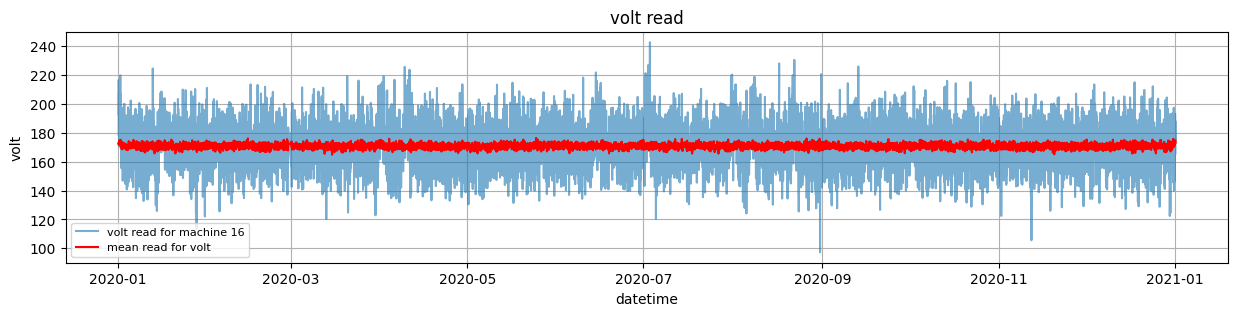

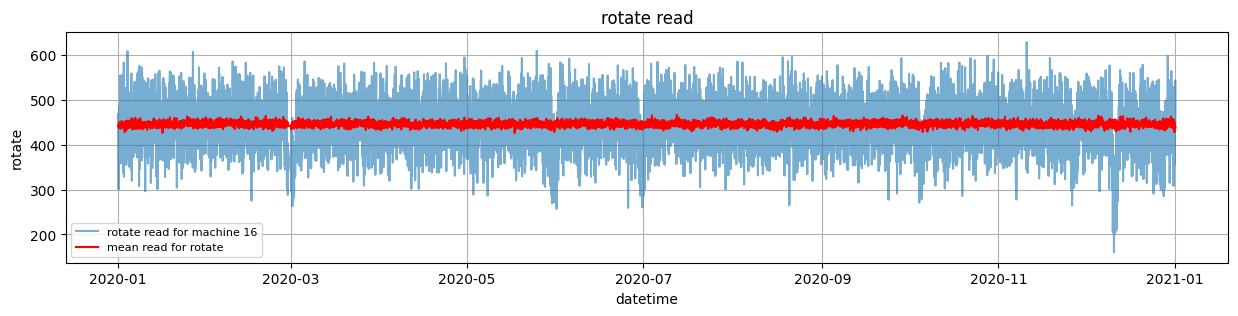

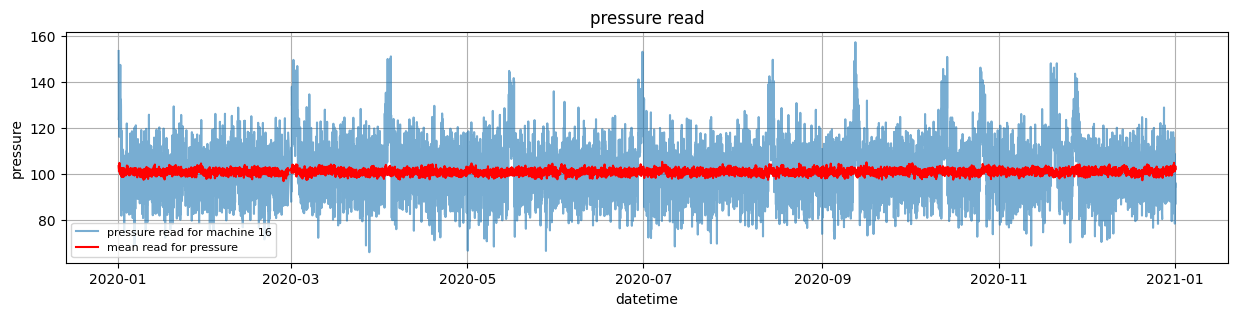

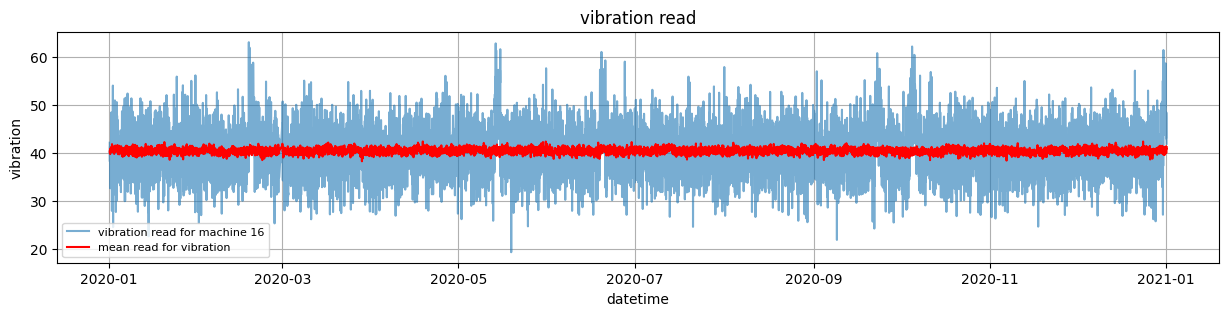

In [ ]:
# Sensor time series

sensors = ["volt", "rotate", "pressure", "vibration"]
for sensor in sensors:
    fig = plt.figure(figsize=(15, 3))
    plt.grid(True)
    sns.lineplot(x = 'datetime', y = sensor, data=df_telemetry[df_telemetry['machineID']==mac_ID], alpha = 0.6, label=f'{sensor} read for machine {mac_ID}') # Selected machine
    # Mean of all machines
    data_mean_all = pd.DataFrame(df_telemetry.groupby("datetime")[sensor].mean()).rename(columns={sensor: sensor}).reset_index()
    sns.lineplot(x = 'datetime', y = sensor, data=data_mean_all, alpha = 1, label=f'mean read for {sensor}', color = 'red')
    plt.legend(loc="lower left", fontsize=8)
    plt.title(f"{sensor} read")
    
    plt.show()

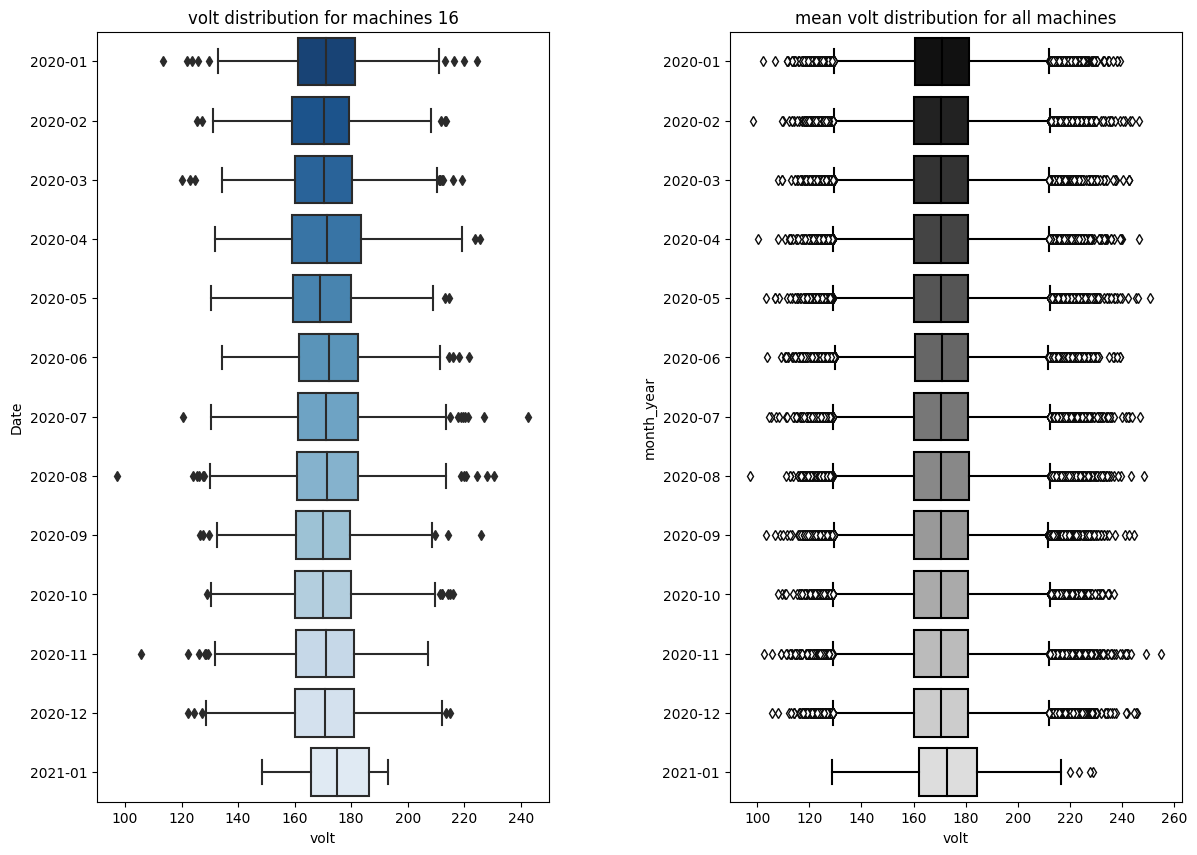

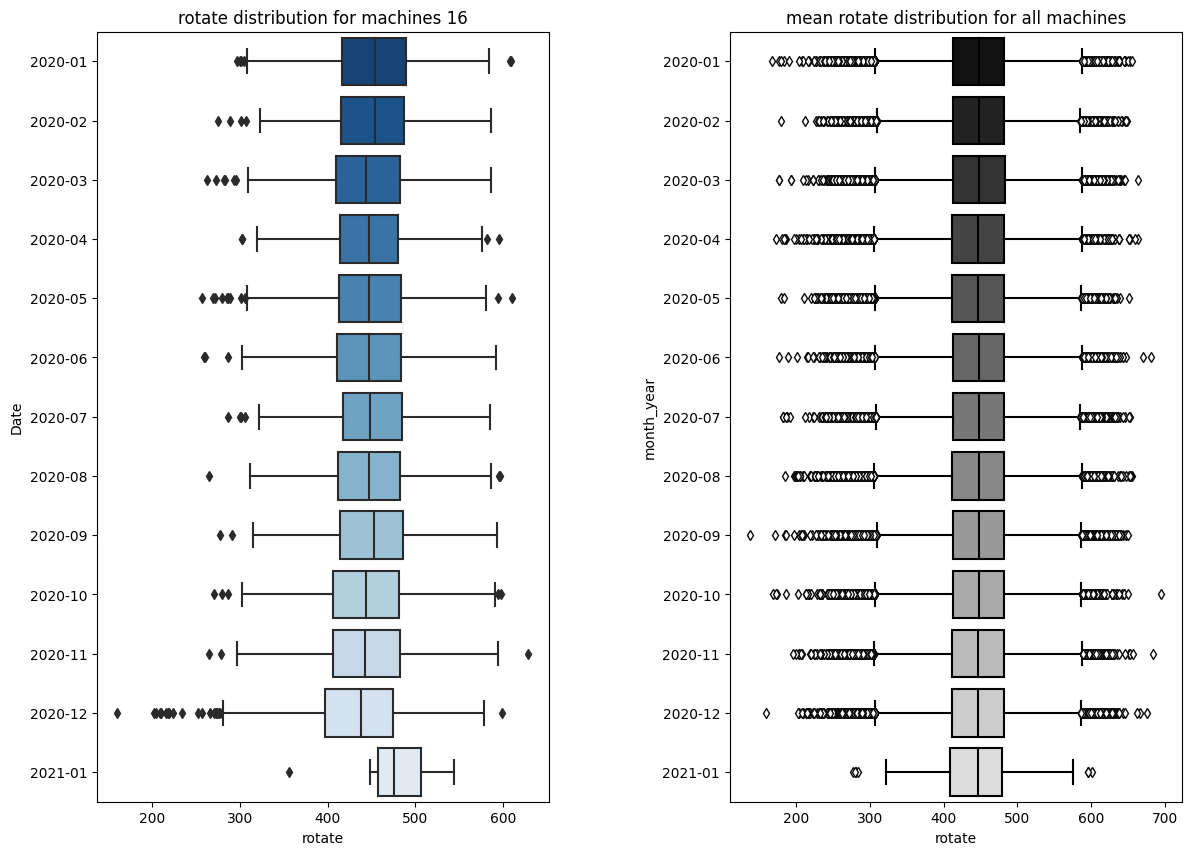

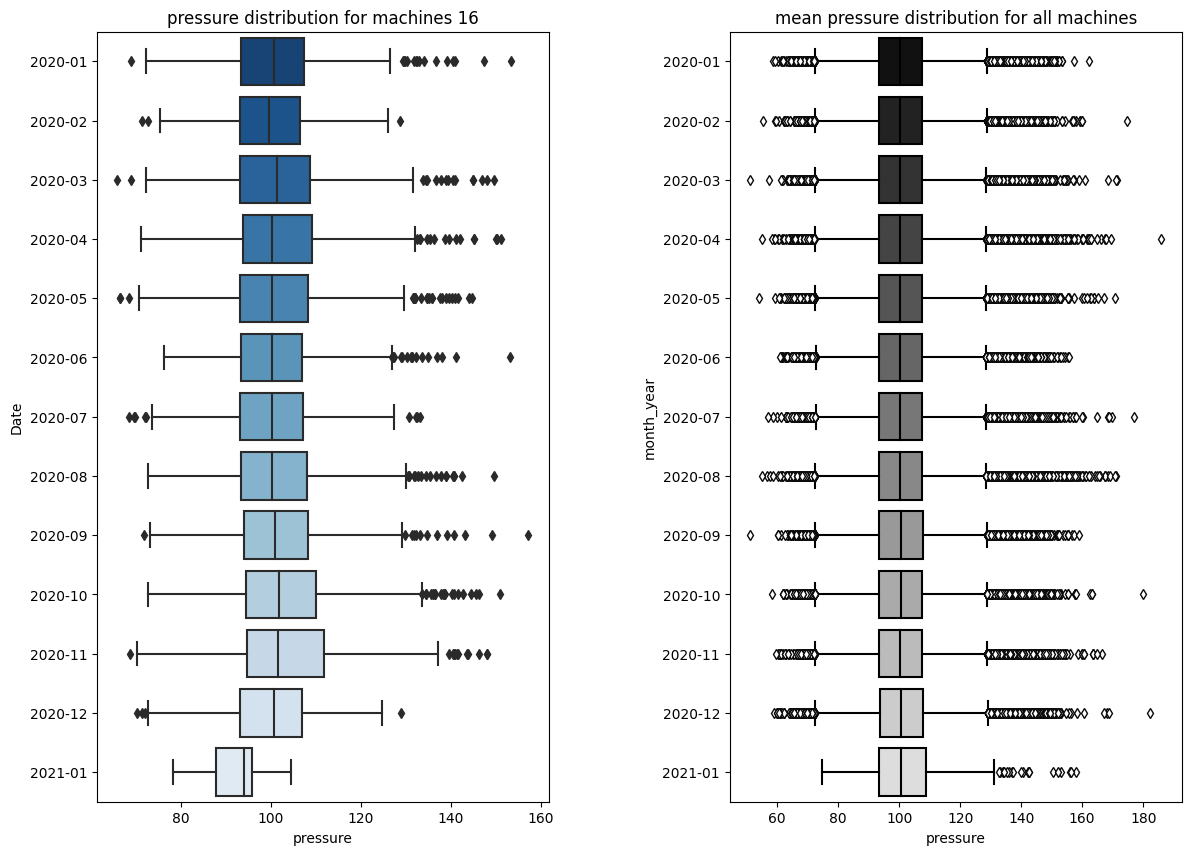

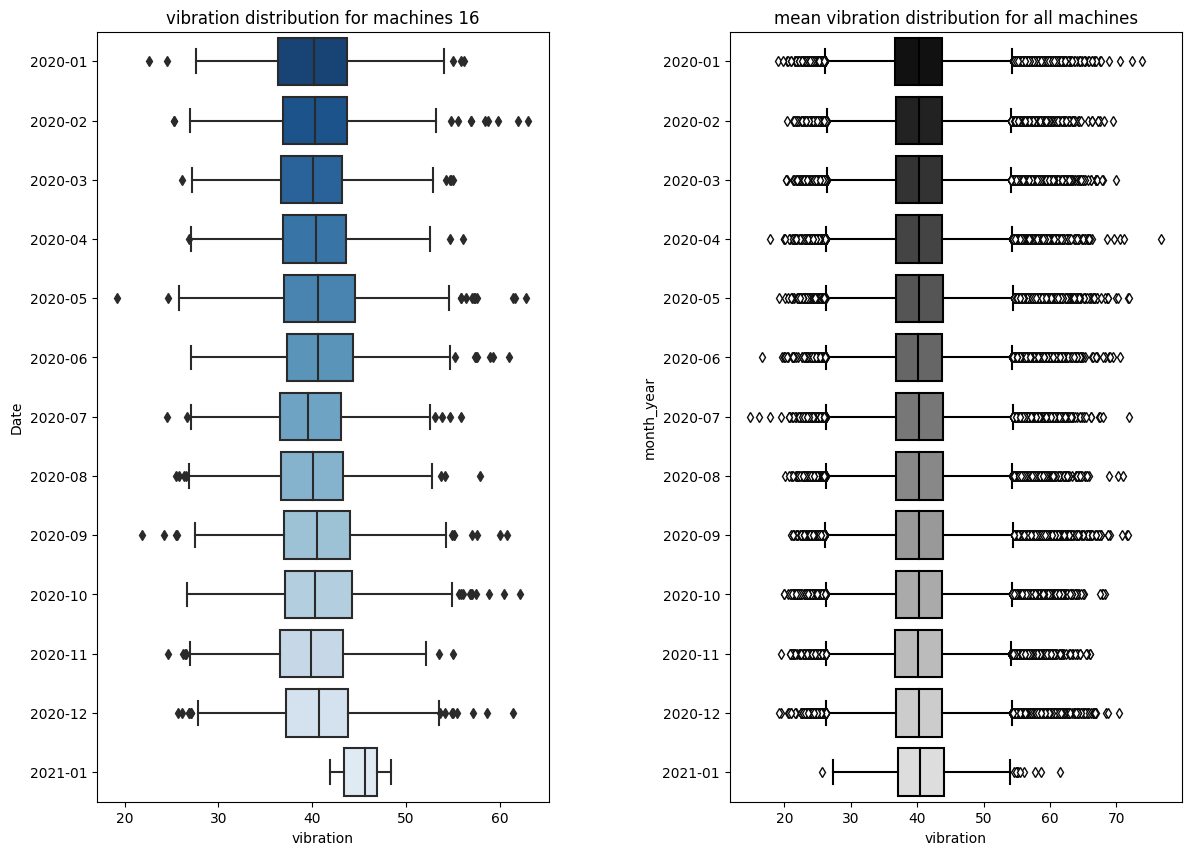

In [ ]:
# Distribution over the time

# Grouping by month and year
df_telemetry['month_year'] = df_telemetry['datetime'].dt.to_period('M')

sensors = ["volt", "rotate", "pressure", "vibration"]

# Box-plot
for sensor in sensors:

    fig, axs = plt.subplots(ncols=2, figsize=(14, 10))
    sns.boxplot(data=df_telemetry[df_telemetry['machineID']==mac_ID], x = sensor, y = "month_year", ax= axs[0], palette = sns.color_palette("Blues_r", n_colors=14))
    sns.boxplot(data=df_telemetry, x = sensor, y = "month_year",ax= axs[1], boxprops=dict( edgecolor='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'),
            medianprops=dict(color='black'),
            flierprops=dict(markerfacecolor="white"), palette = sns.color_palette("gray", n_colors=14))
    
    # Mean of all machines
    axs[0].set_ylabel('Date')
    plt.subplots_adjust(wspace=0.4)
    axs[0].set_title(f"{sensor} distribution for machines {mac_ID}")
    axs[1].set_title(f"mean {sensor} distribution for all machines")
    
    plt.show()
    


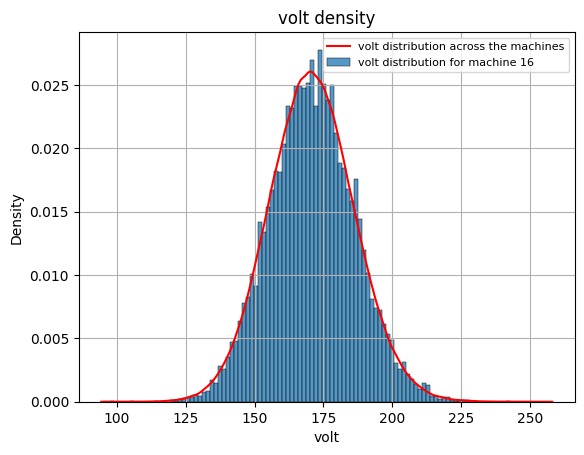

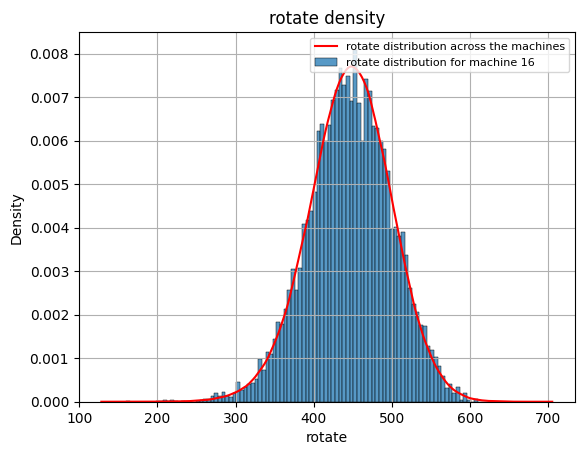

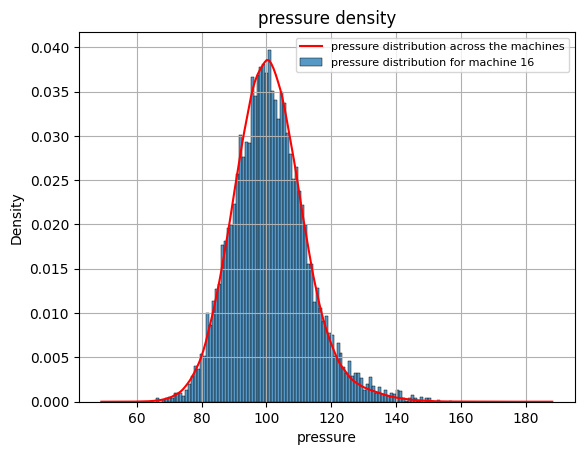

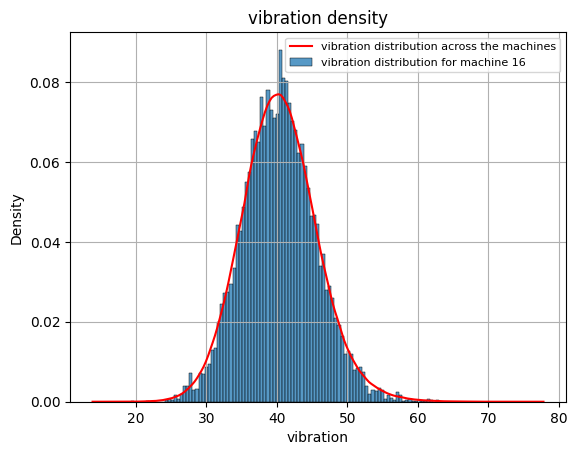

In [ ]:
# Frequency distribution of sensors


# Box-plot
for sensor in sensors:

    plt.grid(True, zorder = 0)
    sns.histplot(data=df_telemetry[df_telemetry['machineID']==mac_ID], x = sensor, bins = 100, stat='density', label=f"{sensor} distribution for machine {mac_ID}")
    sns.kdeplot(data=df_telemetry, x = sensor, color = 'red', label = f"{sensor} distribution across the machines")
    plt.legend(loc="upper right", fontsize=8)
    plt.title(f"{sensor} density")
    
    plt.show()
    

   

### Errors EDA

In [ ]:
# General View 
df_errors.head()

,datetime,machineID,errorID
0,2020-01-01 06:00:00,24,error1
1,2020-01-01 06:00:00,73,error4
2,2020-01-01 06:00:00,81,error1
3,2020-01-01 07:00:00,43,error3
4,2020-01-01 08:00:00,14,error4


In [ ]:
# Overview
print("Shape:")
print(df_errors.shape)
print("Types:")
print(df_errors.dtypes)
print("\n")
print("Null values count:")
print(df_errors.isnull().sum())
print("\n")
print("NaN values count:")
print(df_errors.isna().sum())
print("\n")
print("Duplicate:")
print(df_errors.duplicated(subset=['datetime','machineID','errorID']).sum())
print("\n")

Shape:
(3919, 3)
Types:
datetime     datetime64[ns]
machineID             int64
errorID              object
dtype: object


Null values count:
datetime     0
machineID    0
errorID      0
dtype: int64


NaN values count:
datetime     0
machineID    0
errorID      0
dtype: int64


Duplicate:
0




In [ ]:
# Changing types
df_errors["errorID"] = df_errors["errorID"].astype('category')

In [ ]:
# Basic statistics
(df_errors.describe(datetime_is_numeric=True))

,datetime,machineID
count,3919,3919.000000
mean,2020-06-30 23:36:34.539423232,51.044654
min,2020-01-01 06:00:00,1.000000
25%,2020-03-31 05:00:00,25.000000
50%,2020-07-01 06:00:00,51.000000
75%,2020-10-01 15:00:00,77.000000
max,2021-01-01 05:00:00,100.000000
std,NaN,28.954988


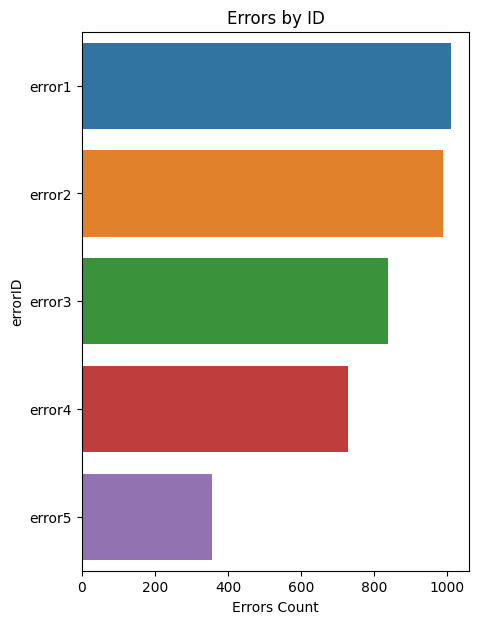

In [ ]:
# Count the errors 

fig = plt.figure(figsize=(5, 7))

ax = sns.countplot(data=df_errors, y = "errorID", order=sorted(df_errors['errorID'].unique()))
ax.set_xlabel('Errors Count')
plt.title(f"Errors by ID")
plt.show()
plt.show()

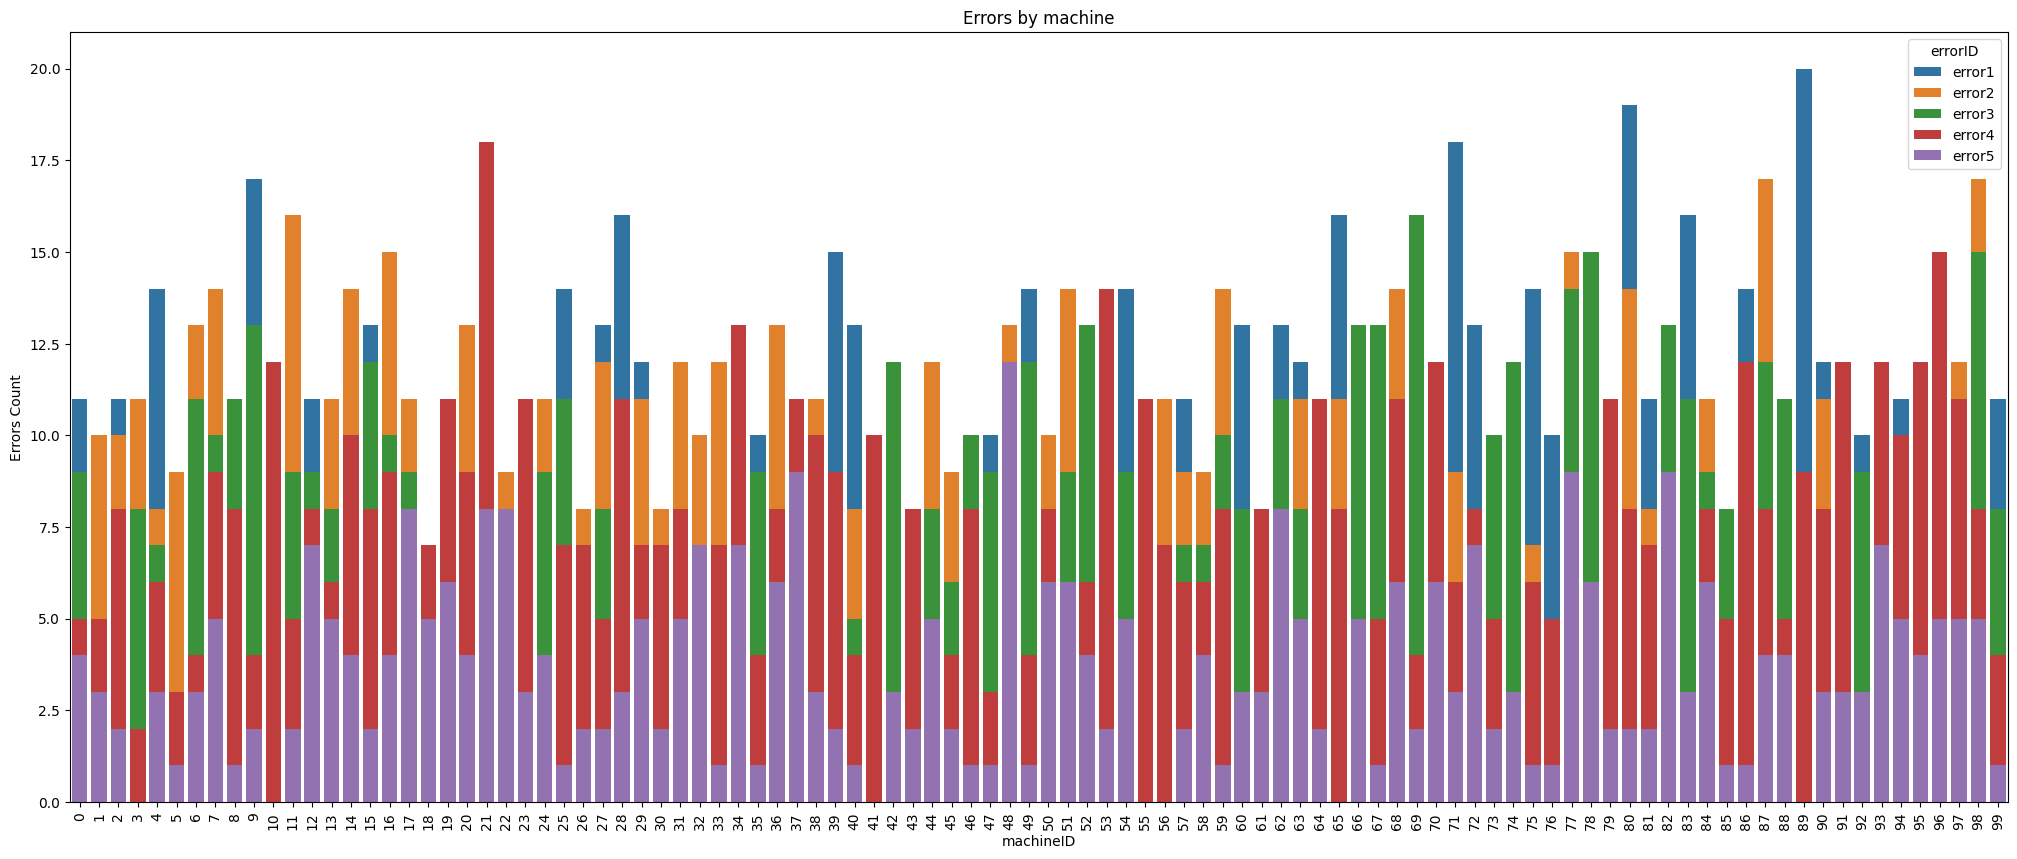

In [ ]:
# Count the errors for different machines

fig = plt.figure(figsize=(25, 10))
ax = sns.countplot(data=df_errors, x = "machineID", hue = "errorID", hue_order = sorted(df_errors['errorID'].unique()), dodge=False)
ax.set_xticklabels(ax.get_xticks(), rotation=90)
plt.title(f"Errors by machine")
ax.set_ylabel('Errors Count')

plt.show()

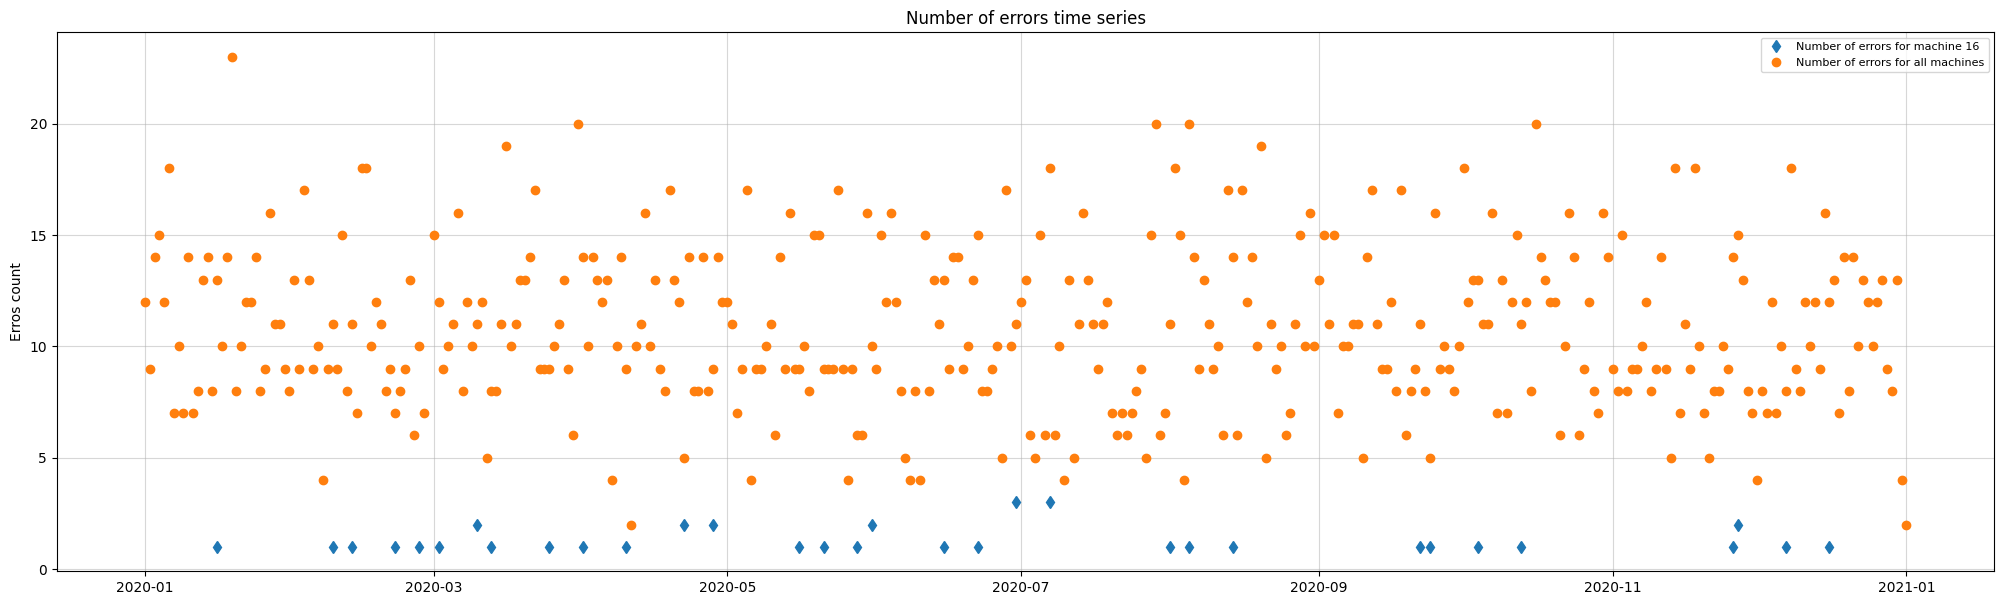

In [ ]:
# Errors occurrences

fig = plt.figure(figsize=(25, 7))

df_errors[df_errors['machineID']==mac_ID]['datetime'].dt.date.value_counts().plot(label=f"Number of errors for machine {mac_ID}", marker='d', linewidth=0)
df_errors['datetime'].dt.date.value_counts().plot(label="Number of errors for all machines", marker='o', linewidth=0)
plt.legend(loc="upper right", fontsize=8)
plt.ylabel('Erros count')
plt.title(f"Number of errors time series")
plt.grid(True, zorder = 0, alpha = 0.5)
plt.show()




### Maintenance EDA

In [ ]:
# General View 
df_maintenance.head()

,datetime,machineID,comp
0,2019-06-01 06:00:00,1,comp2
1,2019-06-01 06:00:00,6,comp2
2,2019-06-01 06:00:00,9,comp1
3,2019-06-01 06:00:00,9,comp2
4,2019-06-01 06:00:00,11,comp2


In [ ]:
# Overview
print("Shape:")
print(df_maintenance.shape)
print("Types:")
print(df_maintenance.dtypes)
print("\n")
print("Null values count:")
print(df_maintenance.isnull().sum())
print("\n")
print("NaN values count:")
print(df_maintenance.isna().sum())
print("\n")
print("Duplicate:")
print(df_maintenance.duplicated(subset=['datetime','machineID','comp']).sum())
print("\n")

Shape:
(3286, 3)
Types:
datetime     datetime64[ns]
machineID             int64
comp                 object
dtype: object


Null values count:
datetime     0
machineID    0
comp         0
dtype: int64


NaN values count:
datetime     0
machineID    0
comp         0
dtype: int64


Duplicate:
0




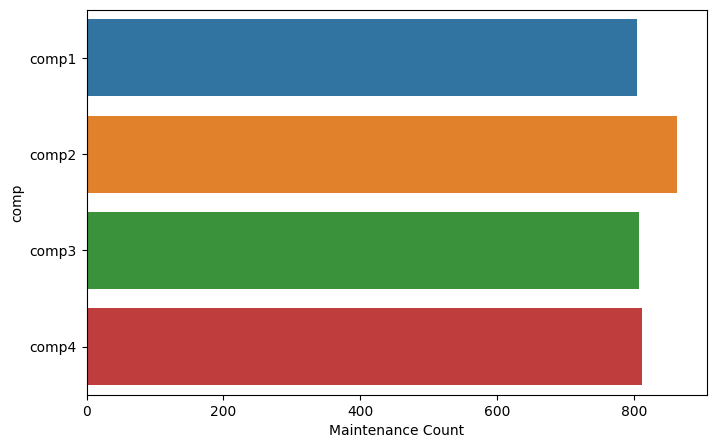

In [ ]:
# Count the components that need maintenance

fig = plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df_maintenance, y = "comp",order=sorted(df_maintenance['comp'].unique()))
ax.set_xlabel('Maintenance Count')
plt.show()

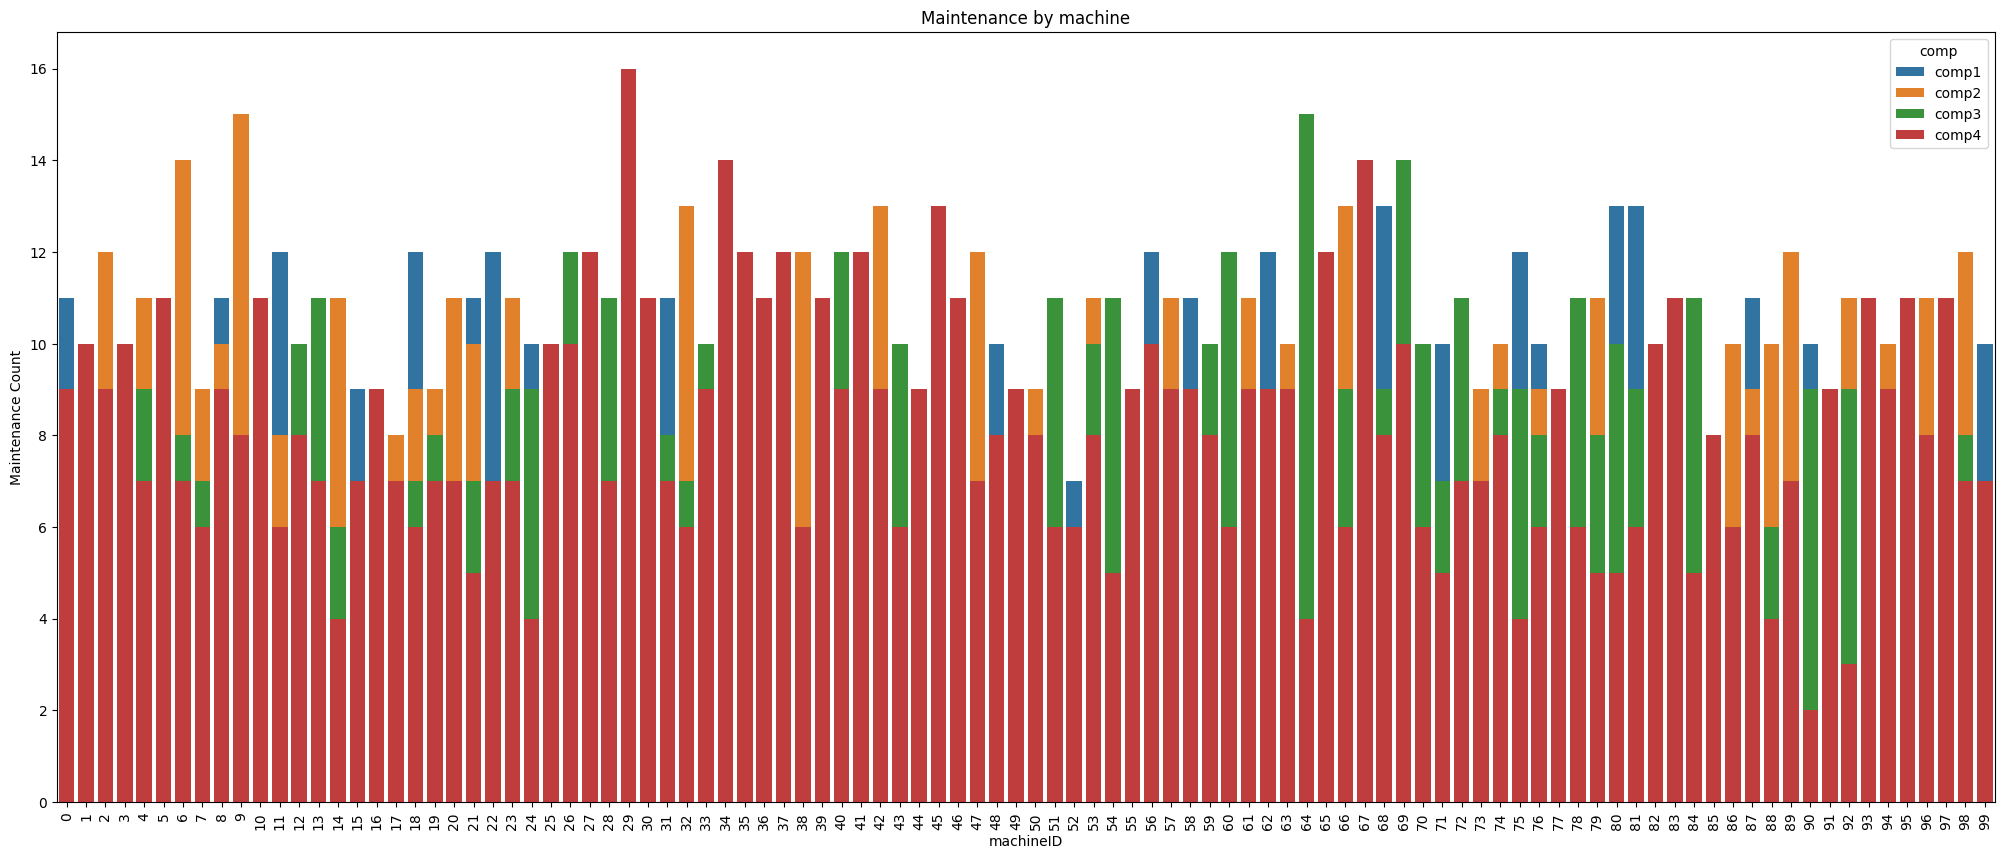

In [ ]:
# Count the maintenance for different machines

fig = plt.figure(figsize=(25, 10))
ax = sns.countplot(data=df_maintenance, x = "machineID", hue = "comp", hue_order = sorted(df_maintenance['comp'].unique()), dodge=False)
ax.set_xticklabels(ax.get_xticks(), rotation=90)
plt.title(f"Maintenance by machine")
ax.set_ylabel('Maintenance Count')

plt.show()

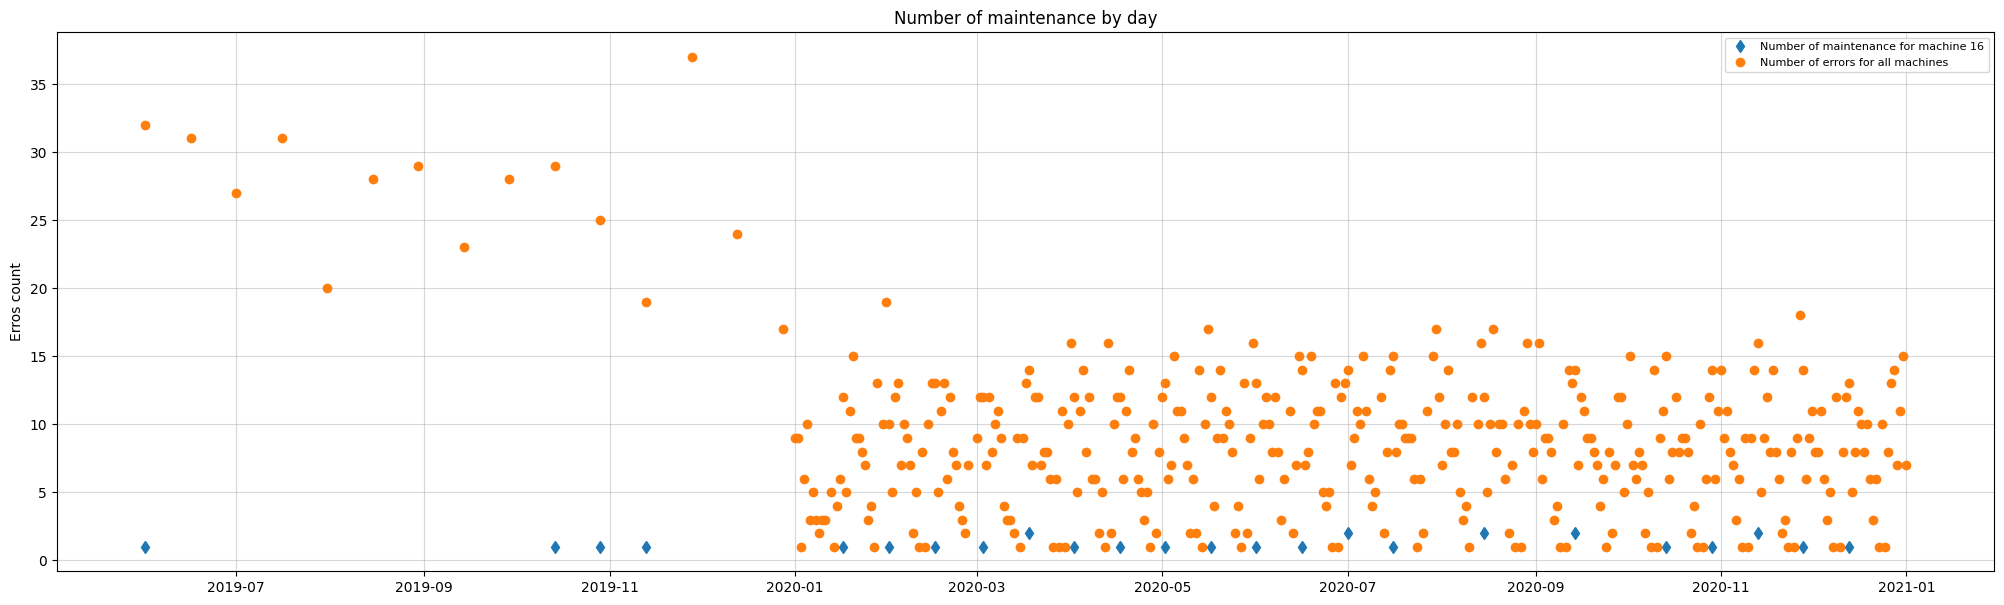

In [ ]:
# Maintenances made

fig = plt.figure(figsize=(25, 7))

df_maintenance[df_maintenance['machineID']==mac_ID]['datetime'].dt.date.value_counts().plot(label=f"Number of maintenance for machine {mac_ID}", marker='d', linewidth=0)
df_maintenance['datetime'].dt.date.value_counts().plot(label="Number of errors for all machines", marker='o', linewidth=0)
plt.legend(loc="upper right", fontsize=8)
plt.ylabel('Erros count')
plt.title(f"Number of maintenance by day")
plt.grid(True, zorder = 0, alpha = 0.5)
plt.show()

In [ ]:
mask = df_maintenance['datetime'].dt.date >= pd.to_datetime('2020-01-01').date()
counts = df_maintenance.loc[mask, 'datetime'].dt.date.value_counts()
counts.sum()

2886

### Failure EDA

In [ ]:
# General View 
df_failures.head()

,datetime,machineID,failure
0,2020-01-02 03:00:00,16,comp1
1,2020-01-02 03:00:00,16,comp3
2,2020-01-02 03:00:00,17,comp4
3,2020-01-02 03:00:00,22,comp1
4,2020-01-02 03:00:00,35,comp1


In [ ]:
# Overview
print("Shape:")
print(df_failures.shape)
print("Types:")
print(df_failures.dtypes)
print("\n")
print("Null values count:")
print(df_failures.isnull().sum())
print("\n")
print("NaN values count:")
print(df_failures.isna().sum())
print("\n")
print("Duplicate:")
print(df_failures.duplicated(subset=['datetime','machineID','failure']).sum())
print("\n")

Shape:
(761, 3)
Types:
datetime     datetime64[ns]
machineID             int64
failure              object
dtype: object


Null values count:
datetime     0
machineID    0
failure      0
dtype: int64


NaN values count:
datetime     0
machineID    0
failure      0
dtype: int64


Duplicate:
0




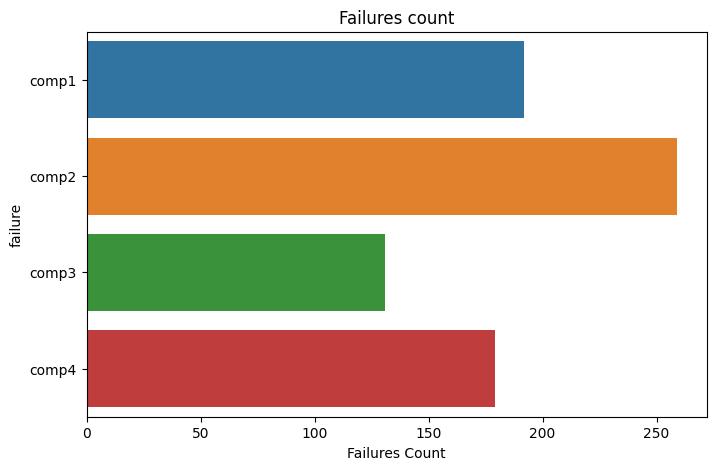

In [ ]:
# Count the components that presented failures

fig = plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df_failures, y = "failure",order=sorted(df_failures['failure'].unique()))
plt.title("Failures count")
ax.set_xlabel('Failures Count')
plt.show()

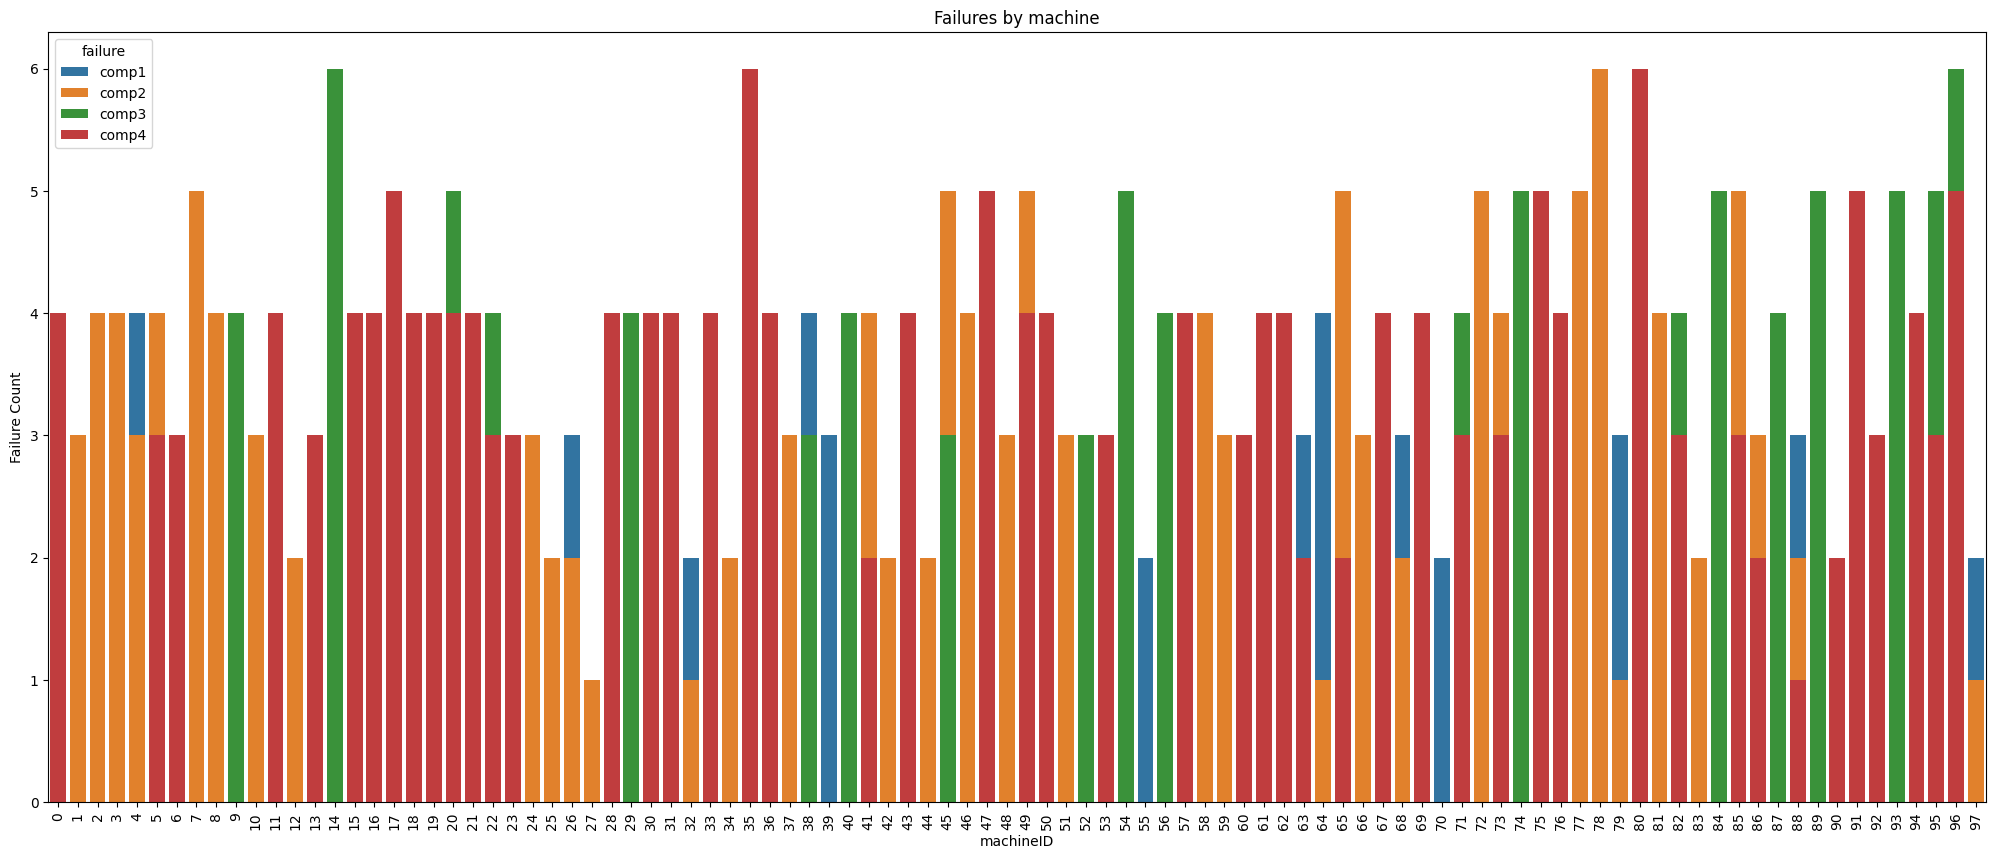

In [ ]:
# Count the maintenance for different machines

fig = plt.figure(figsize=(25, 10))
ax = sns.countplot(data=df_failures, x = "machineID", hue = "failure", hue_order=sorted(df_failures['failure'].unique()), dodge=False)
ax.set_xticklabels(ax.get_xticks(), rotation=90)
plt.title(f"Failures by machine")
ax.set_ylabel('Failure Count')

plt.show()

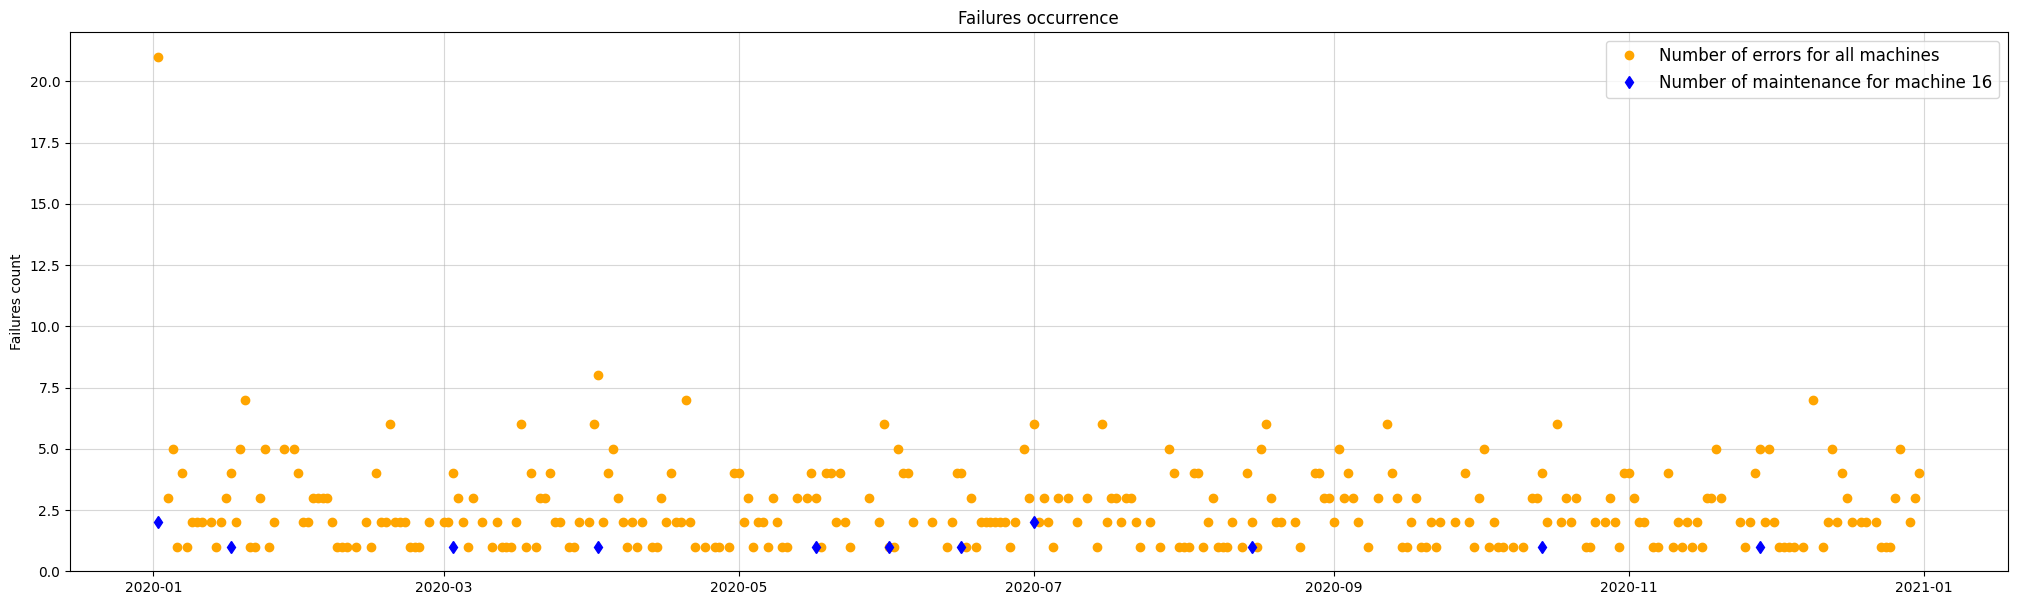

In [ ]:
# Failures occurrence 

fig = plt.figure(figsize=(25, 7))


df_failures['datetime'].dt.date.value_counts().plot(label="Number of errors for all machines", marker='o', linewidth=0, color = 'orange')
df_failures[df_failures['machineID']==mac_ID]['datetime'].dt.date.value_counts().plot(label=f"Number of maintenance for machine {mac_ID}", 
                                                                                      marker='d', linewidth=0, color = 'blue')
plt.legend(loc="upper right", fontsize=12)
plt.ylabel('Failures count')
plt.title(f"Failures occurrence")
plt.grid(True, zorder = 0, alpha = 0.5)
plt.show()

### Machines Data

In [ ]:
# General View 
df_machines.head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [ ]:
# Overview
print("Shape:")
print(df_machines.shape)
print("Types:")
print(df_machines.dtypes)
print("\n")
print("Null values count:")
print(df_machines.isnull().sum())
print("\n")
print("NaN values count:")
print(df_machines.isna().sum())
print("\n")
print("Duplicate:")
print(df_machines.duplicated(subset=['machineID','model']).sum())
print("\n")

Shape:
(100, 3)
Types:
machineID     int64
model        object
age           int64
dtype: object


Null values count:
machineID    0
model        0
age          0
dtype: int64


NaN values count:
machineID    0
model        0
age          0
dtype: int64


Duplicate:
0




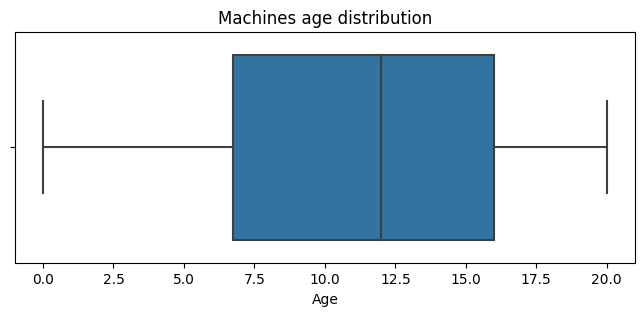

In [ ]:
# Age distribution of machines

fig = plt.figure(figsize=(8, 3))
sns.boxplot(data=df_machines, x = 'age')
plt.xlabel('Age')
plt.title(f"Machines age distribution")

plt.show()

### Unified Analysis

Mean MTBE: 219.42427619147577
Mean MTBE: 216.55801282051283


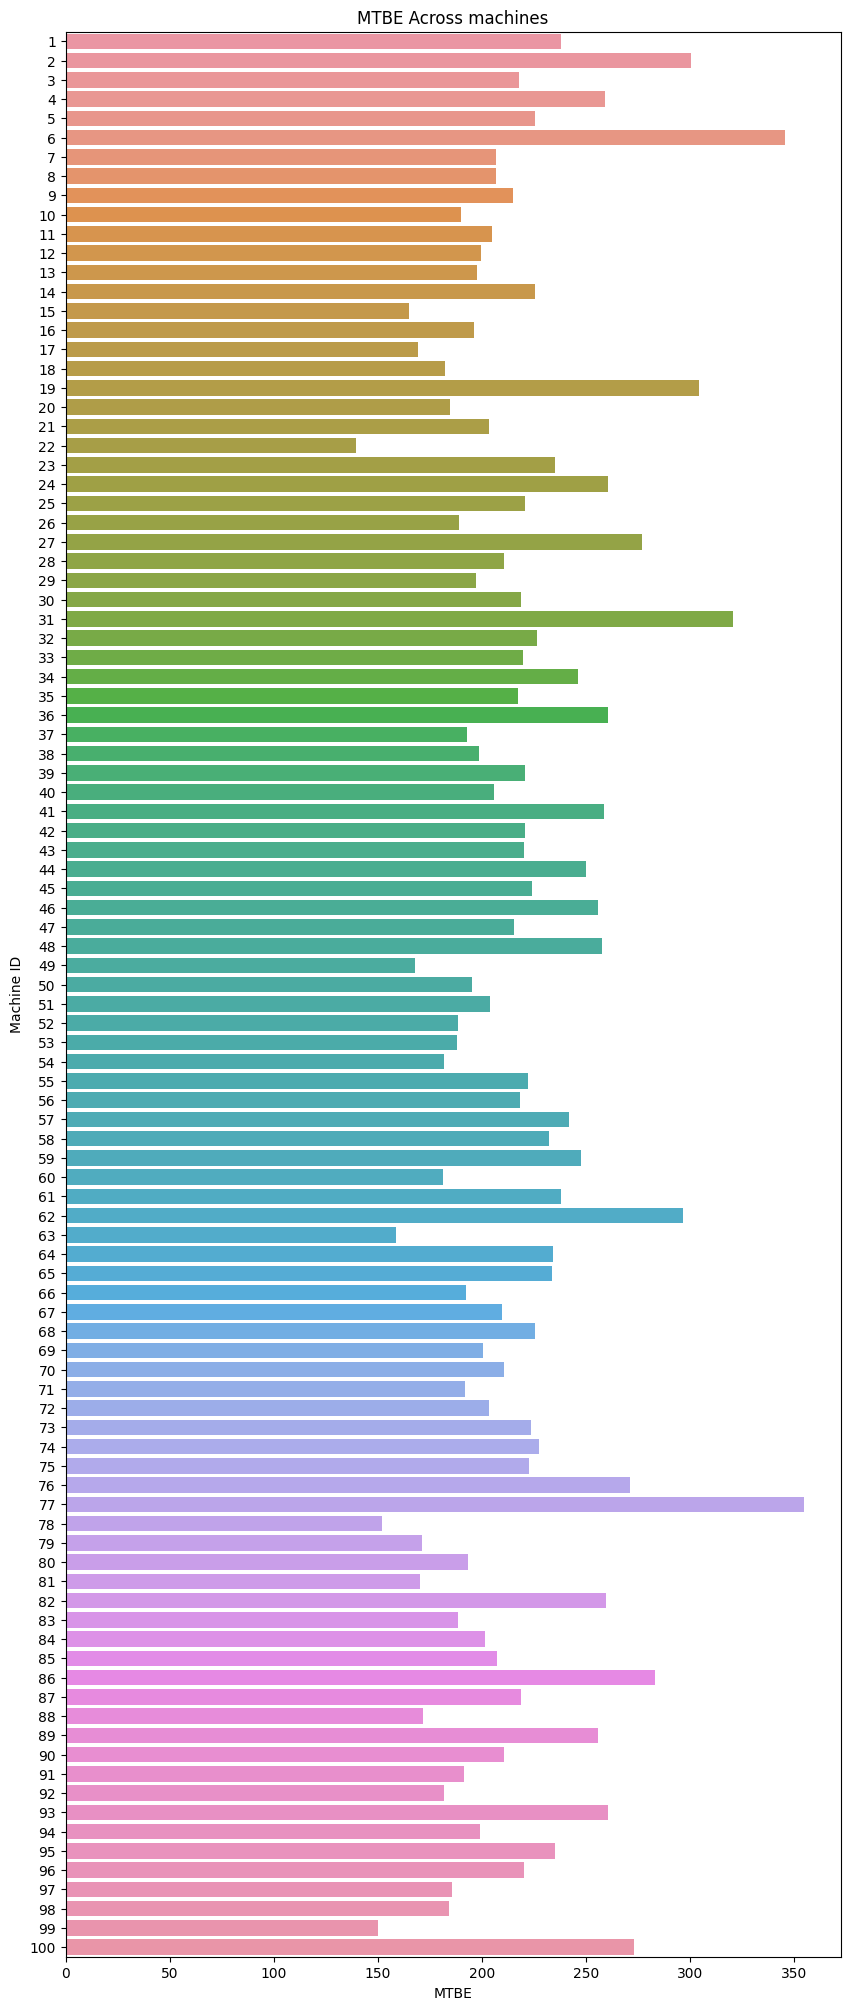

In [ ]:
# Mean time between errors 

df_mean_time_error = df_errors.sort_values('datetime')
time_between_errors = df_mean_time_error.groupby('machineID')['datetime'].diff().dt.total_seconds() # Sort the DataFrame by datetime column
# Calculate the time between each failure for each machine
uptime_and_errors = df_mean_time_error.groupby('machineID').agg({'datetime': lambda x: (x.max() - x.min()).total_seconds(), 'machineID': 'count'})
# Group the DataFrame by machineID and calculate uptime and number of failures for each machine
uptime_and_errors['MTBE'] = (uptime_and_errors['datetime'] / uptime_and_errors['machineID'])/3600

df_MTBE = uptime_and_errors.drop(['machineID','datetime'], axis=1)
df_MTBE= df_MTBE.reset_index()
df_MTBE=df_MTBE.astype({'machineID': 'category'})

mean_MTBE = df_MTBE['MTBE'].mean()
median_MTBE = df_MTBE['MTBE'].median()
print(f'Mean MTBE: {mean_MTBE}')
print(f'Mean MTBE: {median_MTBE}')
# Plot
fig = plt.figure(figsize=(10, 25))

ax = sns.barplot(data=df_MTBE, y = "machineID", x = "MTBE", order=sorted(df_MTBE['machineID'].unique()))
plt.title("MTBE Across machines")
ax.set_ylabel('Machine ID')
ax.set_xlabel('MTBE')
plt.show()

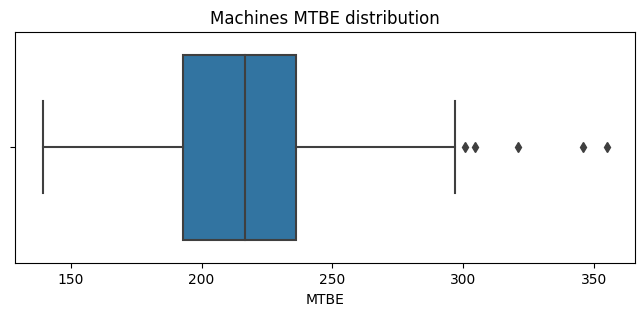

In [ ]:
# Distribution of MTBE

fig = plt.figure(figsize=(8, 3))
sns.boxplot(data=df_MTBE, x = 'MTBE')
plt.xlabel('MTBE')
plt.title(f"Machines MTBE distribution")

plt.show()

Mean MTBF: 1087.3269163614757
Median MTBF: 912.8333333333333


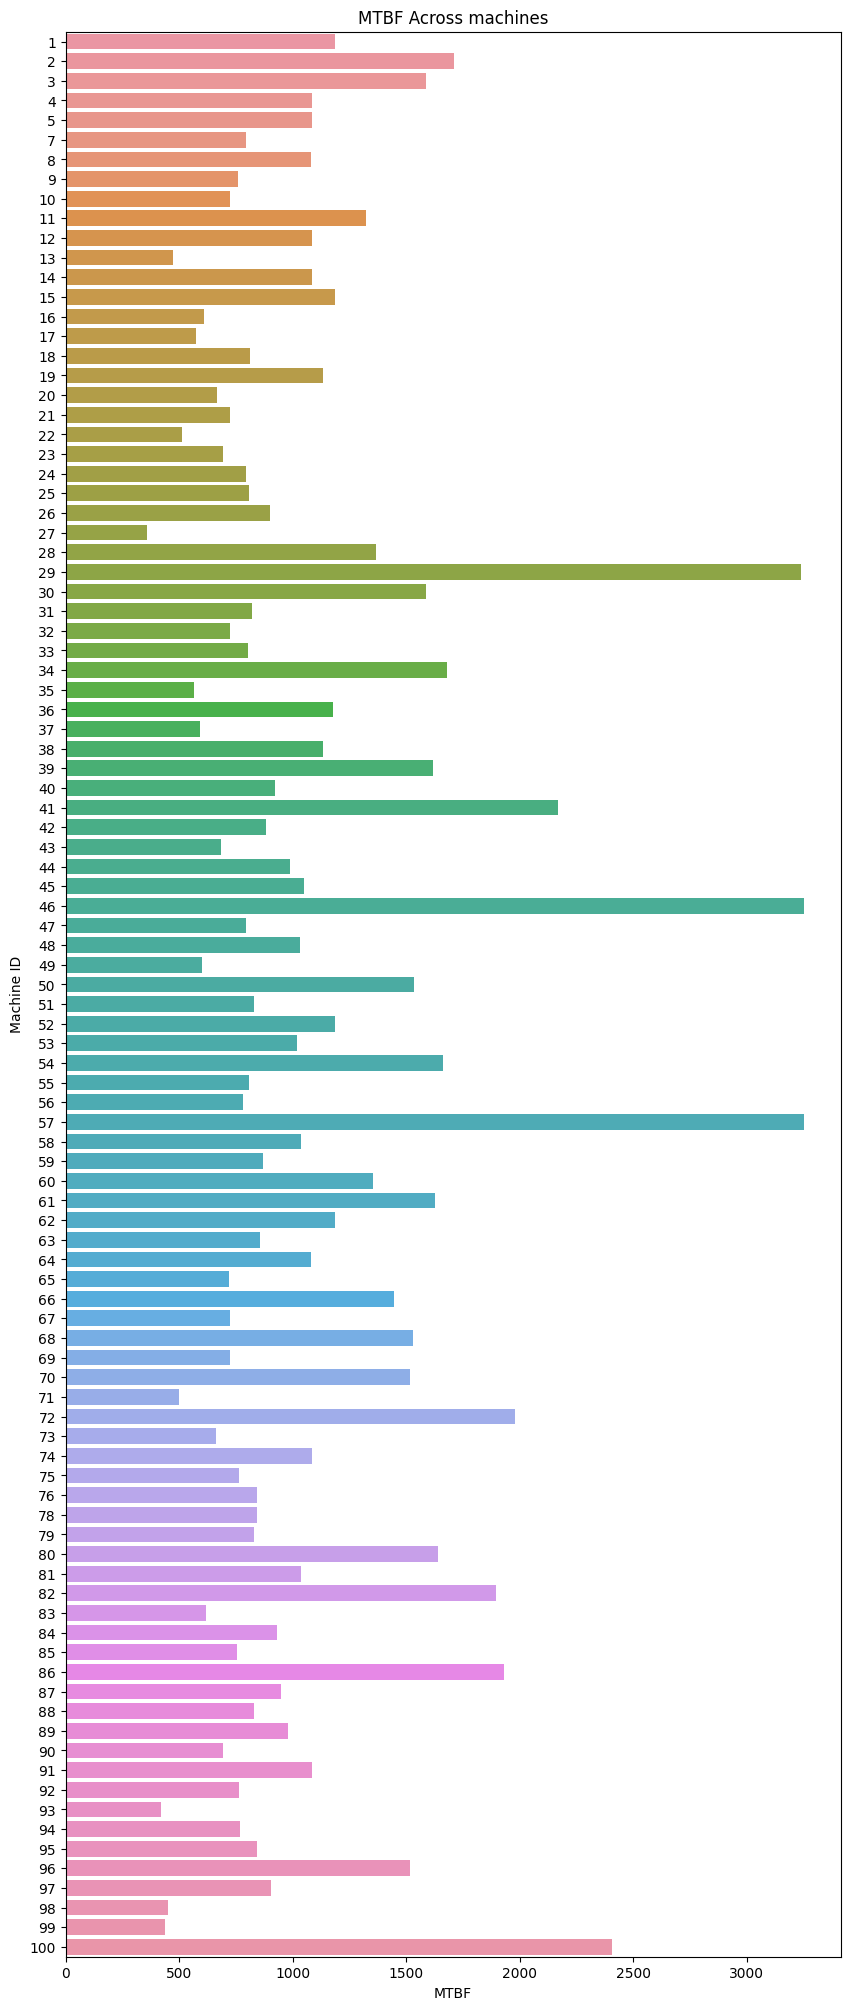

In [ ]:
# Mean time between failures

# Mean time between errors 

df_mean_time_failures = df_failures.drop('failure', axis = 1).sort_values('datetime') # Sort the DataFrame by datetime column

# Calculate the time between each failure for each machine
uptime_and_failures = df_mean_time_failures.groupby('machineID').agg({'datetime': lambda x: (x.max() - x.min()).total_seconds(), 'machineID': 'count'})
# Group the DataFrame by machineID and calculate uptime and number of failures for each machine
uptime_and_failures['MTBF'] = (uptime_and_failures['datetime'] / uptime_and_failures['machineID'])/3600

df_MTBF = uptime_and_failures.drop(['machineID','datetime'], axis=1)
df_MTBF= df_MTBF.reset_index()
df_MTBF=df_MTBF.astype({'machineID': 'category'})

mean_MTBF = df_MTBF['MTBF'].mean()
median_MTBF = df_MTBF['MTBF'].median()

print(f'Mean MTBF: {mean_MTBF}')
print(f'Median MTBF: {median_MTBF}')
# Plot
fig = plt.figure(figsize=(10, 25))

ax = sns.barplot(data=df_MTBF, y = "machineID", x = "MTBF", order=sorted(df_MTBF['machineID'].unique()))
plt.title("MTBF Across machines")
ax.set_ylabel('Machine ID')
ax.set_xlabel('MTBF')
plt.show()

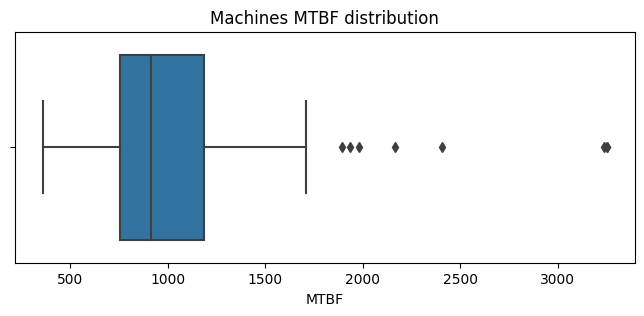

In [ ]:
# Distribution of MTBF

fig = plt.figure(figsize=(8, 3))
sns.boxplot(data=df_MTBF, x = 'MTBF')
plt.xlabel('MTBF')
plt.title(f"Machines MTBF distribution")

plt.show()

Mean time without stopping: 324.9417905844542
Median without stopping: 321.33094812164575


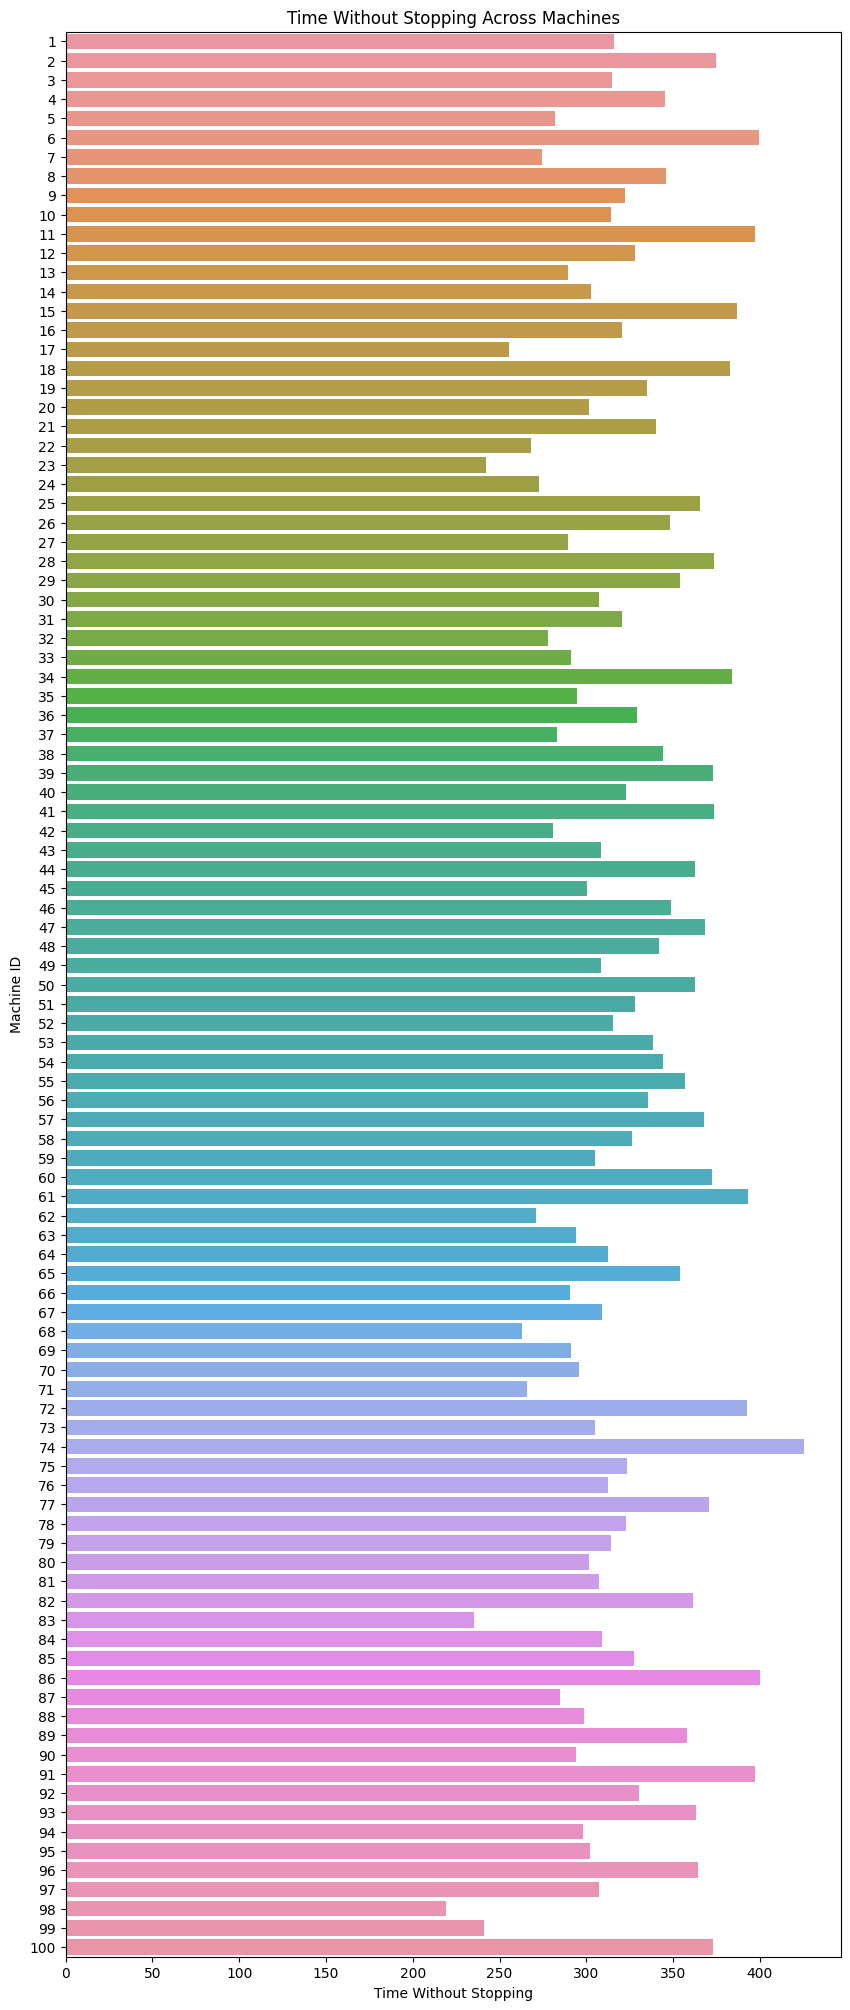

In [ ]:
# Operational time

# Maintenance dataset drop
df_maintenance_drop = df_maintenance.drop('comp', axis = 1).sort_values('datetime')
df_maintenance_drop['type'] = "maintenance" # Create a column that indicates the reason that explains why the machine aren't operating

# Type failures
df_mean_time_failures['type'] = "failure"

# Append with the df_mean_time_failures to create a dataset of all times that machines aren't operating
df_not_operational = pd.concat([df_maintenance_drop, df_mean_time_failures], axis=0, ignore_index=True)
df_not_operational = df_not_operational.sort_values(by = 'datetime')

df_not_operational

# Calculating the operational time

# Calculate the time between each not operational state for each machine
uptime_and_not = df_not_operational.groupby('machineID').agg({'datetime': lambda x: (x.max() - x.min()).total_seconds(), 'machineID': 'count'})
# Group the DataFrame by machineID and calculate uptime and number of not operational times for each machine
uptime_and_not['MO'] = (uptime_and_not['datetime'] / uptime_and_not['machineID'])/3600 

df_MO = uptime_and_not.drop(['machineID','datetime'], axis=1)
df_MO= df_MO.reset_index()
df_MO=df_MO.astype({'machineID': 'category'})

mean_MO = df_MO['MO'].mean()
median_MO = df_MO['MO'].median()

print(f'Mean time without stopping: {mean_MO}')
print(f'Median without stopping: {median_MO}')
# Plot
fig = plt.figure(figsize=(10, 25))

ax = sns.barplot(data=df_MO, y = "machineID", x = "MO", order=sorted(df_MO['machineID'].unique()))
plt.title("Time Without Stopping Across Machines")
ax.set_ylabel('Machine ID')
ax.set_xlabel('Time Without Stopping')
plt.show()


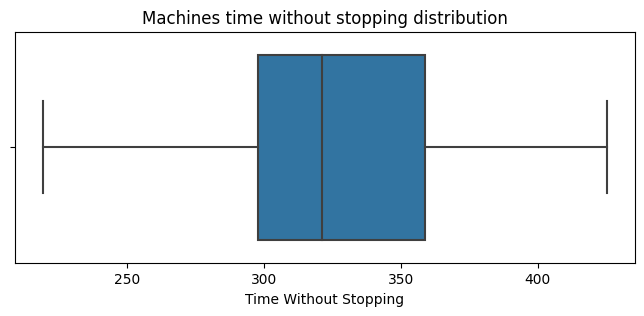

In [ ]:
# Distribution of time without stopping

fig = plt.figure(figsize=(8, 3))
sns.boxplot(data=df_MO, x = 'MO')
plt.xlabel('Time Without Stopping')
plt.title(f"Machines time without stopping distribution")

plt.show()

<AxesSubplot: xlabel='count', ylabel='type'>

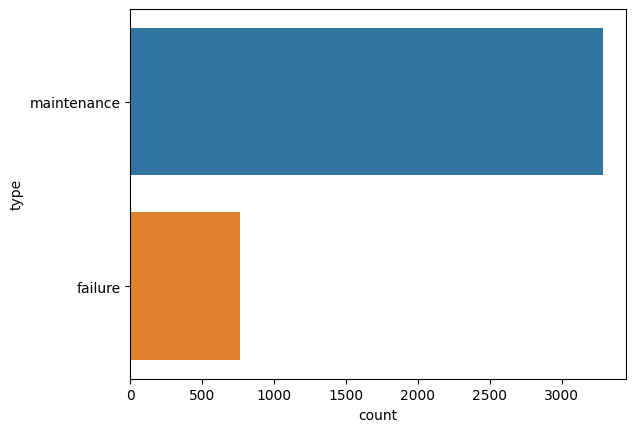

In [ ]:
# Counting the reason for stop

df_not_operational
sns.countplot(data=df_not_operational, y="type")

During a maintenance the machine stops its operation, so to calculate the time between each interruption in it operation. The main reason to stop is maintenance.

The average time between stop is 324.94 hours.

This isn't the best way to represents the operational time. Because we don't know the time of maintenance.

Text(0.5, 1.0, 'Age vs Number of errors')

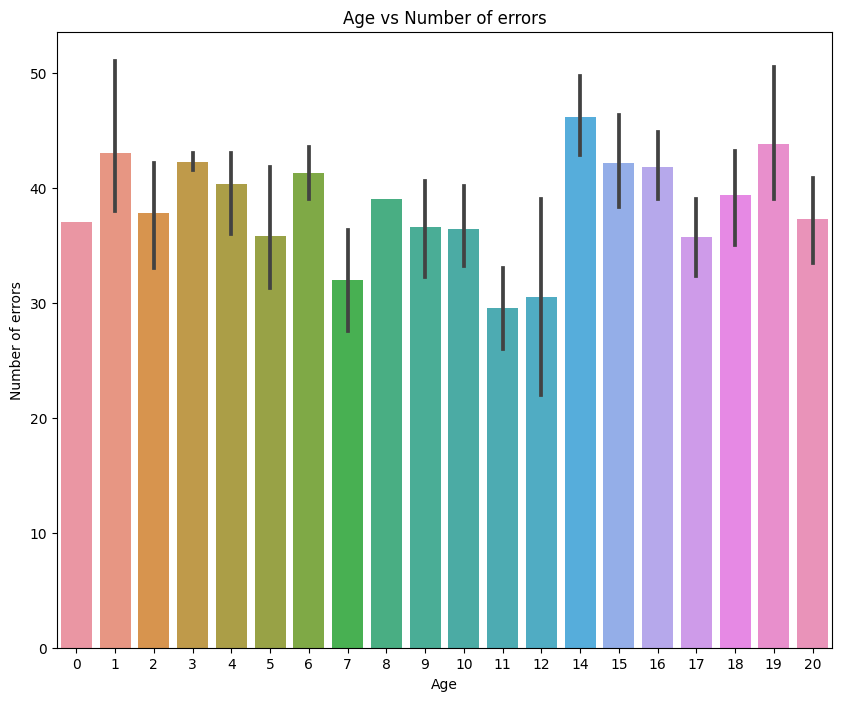

In [ ]:
#   Age and Number of Errors

# Data frame consisting of number of errors across Machines
errors_across_machine = df_errors.groupby("machineID").size() #Machine Id and Number of errors
errors_across_machine = pd.DataFrame(errors_across_machine, columns=["num_errors"]).reset_index()
# Create a dataframe with the machine ID, model, age and number of errors
machines_errors_df = pd.merge(df_machines, errors_across_machine, how='left', on="machineID") # left join in the df_machines on machine ID column
machines_errors_df = machines_errors_df

# Plot
fig = plt.figure(figsize=(10, 8))
sns.barplot(data = machines_errors_df, x = "age", y = "num_errors")
plt.xlabel('Age')
plt.ylabel('Number of errors')
plt.title(f"Age vs Number of errors")


Text(0.5, 1.0, 'Age vs Number of maintenance')

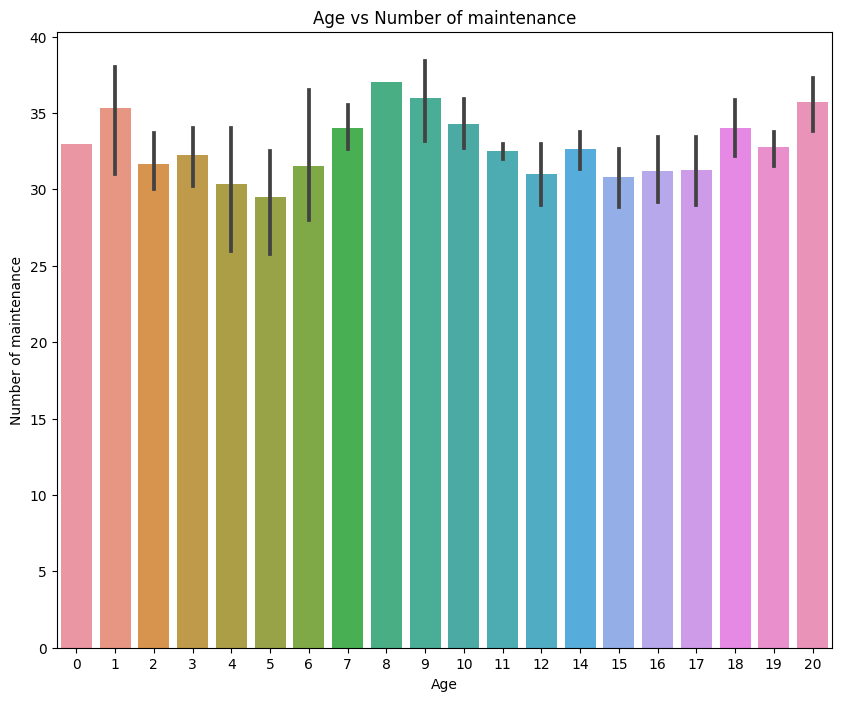

In [ ]:
#   Age and Number of Maintenances

# Data frame consisting of number of maintenances across Machines
maintenance_across_machine = df_maintenance.groupby("machineID").size() #Machine Id and Number of maintenance
maintenance_across_machine = pd.DataFrame(maintenance_across_machine, columns=["num_maintenance"]).reset_index()
# Create a dataframe with the machine ID, model, age and number of maintenance
machines_maintenance_df = pd.merge(df_machines, maintenance_across_machine, how='left', on="machineID") # left join in the df_machines on machine ID column


# Plot
fig = plt.figure(figsize=(10, 8))
sns.barplot(data = machines_maintenance_df, x = "age", y = "num_maintenance")
plt.xlabel('Age')
plt.ylabel('Number of maintenance')
plt.title(f"Age vs Number of maintenance")

c:\Users\airto\anaconda3\envs\yourenvname\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


Text(0.5, 1.0, 'Age vs Number of failures')

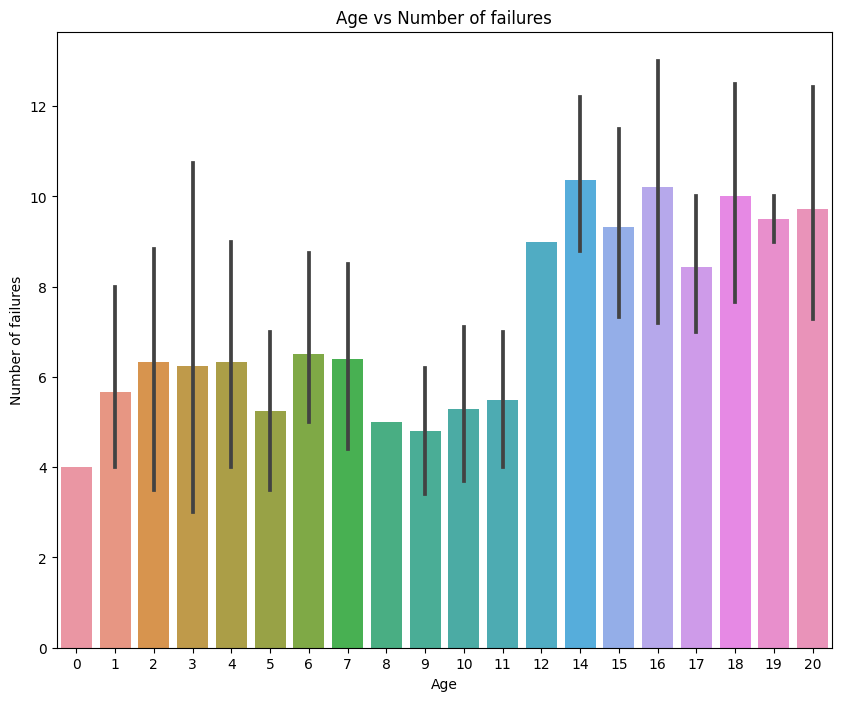

In [ ]:
#   Age and Number of Failures

# Data frame consisting of number of failures across Machines
failures_across_machine = df_failures.groupby("machineID").size() #Machine Id and Number of maintenance
failures_across_machine = pd.DataFrame(failures_across_machine, columns=["num_failures"]).reset_index()
# Create a dataframe with the machine ID, model, age and number of failures
machines_failures_df = pd.merge(df_machines, failures_across_machine, how='left', on="machineID") # left join in the df_machines on machine ID column

# Plot
fig = plt.figure(figsize=(10, 8))
sns.barplot(data = machines_failures_df, x = "age", y = "num_failures")
plt.xlabel('Age')
plt.ylabel('Number of failures')
plt.title(f"Age vs Number of failures")

In [ ]:
# Creating a unique dataframe to analyses the correlation between variables

# Creating that ensembles machine data and telemetry
telemetry_machine_data = pd.merge(df_telemetry,df_machines, how='left', on="machineID")
telemetry_machine_data 

# Creating that ensembles machine data, telemetry and errors occurrences
error_full_dataset = pd.merge(telemetry_machine_data ,df_errors, how='left', on=["datetime","machineID"])

# Creating that ensembles machine data, telemetry and maintenances occurrences
maintenance_full_dataset = pd.merge(telemetry_machine_data ,df_maintenance, how='left', on=["datetime","machineID"])

# Creating that ensembles machine data, telemetry and failures occurrences
failures_full_dataset = pd.merge(telemetry_machine_data ,df_failures, how='left', on=["datetime","machineID"])

# Analyzing the occurrences
occurrences_errors = (1 - error_full_dataset['errorID'].isnull().sum()/len(error_full_dataset))*100
occurrences_maintenance = (1 - maintenance_full_dataset['comp'].isnull().sum()/len(maintenance_full_dataset))*100
occurrences_failures = (1 - failures_full_dataset['failure'].isnull().sum()/len(failures_full_dataset))*100

print(f'The error rate is equal to {occurrences_errors} %')
print(f'The maintenance rate is equal to {occurrences_maintenance} %')
print(f'The failures rate is equal to {occurrences_failures} %')


The error rate is equal to 0.44716871119793167 %
The maintenance rate is equal to 0.3291428258610951 %
The failures rate is equal to 0.08685806638649707 %


In [ ]:
# Error heatmap dataframe
from sklearn.preprocessing import LabelEncoder

# We want to analyse if the error exists or not so, we gonna change the error ID for has error
error_full_dataset['error'] = np.where(error_full_dataset['errorID'].notnull(), 1, 0)
error_full_dataset_logic = error_full_dataset.drop('errorID',axis =1)


# Initialize the LabelEncoder
le = LabelEncoder()

# Identify the string columns
string_cols = [col for col in error_full_dataset_logic.columns if error_full_dataset_logic[col].dtype == 'object']


# Loop through each string column in the dataframe and encode the values
for column in string_cols:
    error_full_dataset_logic[column] = le.fit_transform(error_full_dataset_logic[column])
error_full_dataset_logic


,datetime,machineID,volt,rotate,pressure,vibration,month_year,model,age,error
0,2020-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,2020-01,2,18,0
1,2020-01-01 06:00:00,2,176.558913,424.624162,76.005332,43.767049,2020-01,3,7,0
2,2020-01-01 06:00:00,3,185.482043,461.211137,87.453199,28.216864,2020-01,2,8,0
3,2020-01-01 06:00:00,4,169.710847,463.646727,95.929877,38.400372,2020-01,2,7,0
4,2020-01-01 06:00:00,5,165.082899,452.283576,84.591722,40.298803,2020-01,2,2,0
...,...,...,...,...,...,...,...,...,...,...
876398,2021-01-01 06:00:00,96,157.157424,380.691266,102.885777,35.445739,2021-01,1,10,0
876399,2021-01-01 06:00:00,97,159.607756,458.143799,100.945230,40.011599,2021-01,1,14,0
876400,2021-01-01 06:00:00,98,165.717790,501.520194,114.553412,37.696504,2021-01,1,20,0
876401,2021-01-01 06:00:00,99,168.439623,427.990029,107.899979,44.193151,2021-01,0,14,0


C:\Users\airto\AppData\Local\Temp\ipykernel_7820\2808837821.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(error_full_dataset_logic.corr(),annot=True);


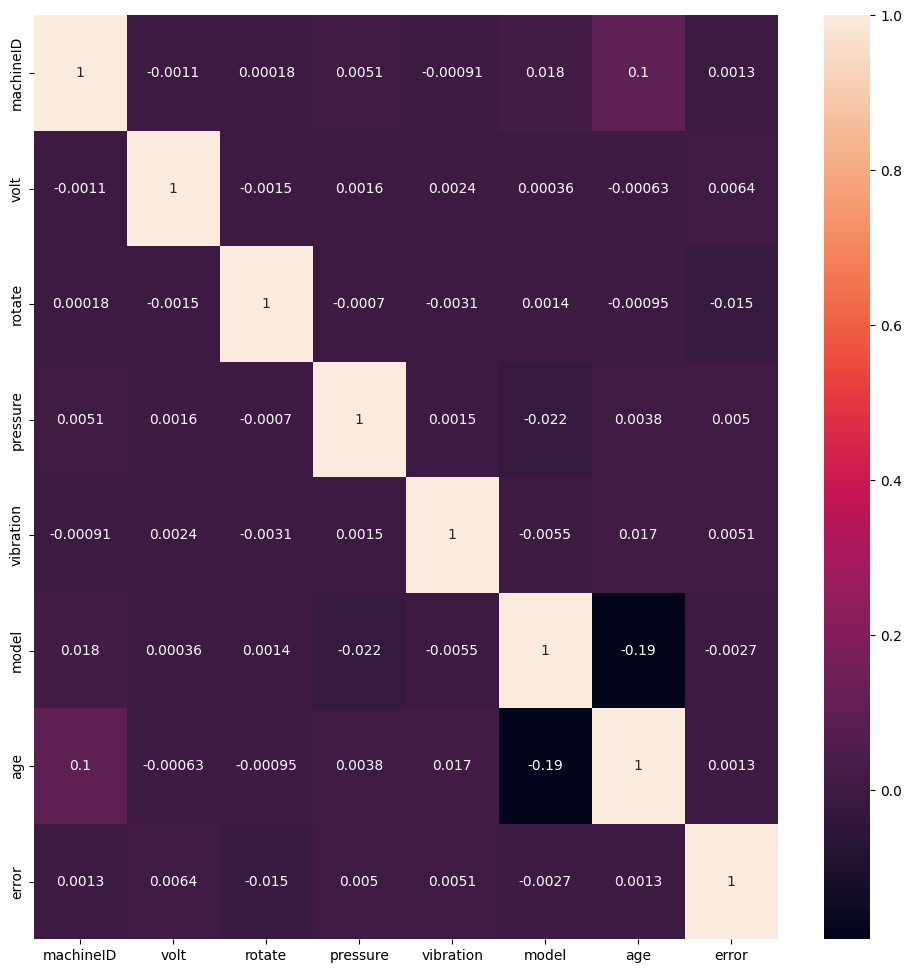

In [ ]:
# Error heatmap

plt.figure(figsize=(12,12))
sns.heatmap(error_full_dataset_logic.corr(),annot=True);
plt.show()

In [ ]:
# Maintenance heatmap dataframe
from sklearn.preprocessing import LabelEncoder

# We want to analyses if the error exists or not so, we gonna change the error ID for has error
maintenance_full_dataset['maintenance'] = np.where(maintenance_full_dataset['comp'].notnull(), 1, 0)
maintenance_full_dataset_logic = maintenance_full_dataset.drop('comp',axis =1)


# Initialize the LabelEncoder
le = LabelEncoder()

# Identify the string columns
string_cols = [col for col in maintenance_full_dataset_logic.columns if maintenance_full_dataset_logic[col].dtype == 'object']

# Initialize the LabelEncoder
le = LabelEncoder()

# Loop through each string column in the dataframe and encode the values
for column in string_cols:
    maintenance_full_dataset_logic[column] = le.fit_transform(maintenance_full_dataset_logic[column])
maintenance_full_dataset_logic

,datetime,machineID,volt,rotate,pressure,vibration,month_year,model,age,maintenance
0,2020-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,2020-01,2,18,0
1,2020-01-01 06:00:00,2,176.558913,424.624162,76.005332,43.767049,2020-01,3,7,0
2,2020-01-01 06:00:00,3,185.482043,461.211137,87.453199,28.216864,2020-01,2,8,0
3,2020-01-01 06:00:00,4,169.710847,463.646727,95.929877,38.400372,2020-01,2,7,0
4,2020-01-01 06:00:00,5,165.082899,452.283576,84.591722,40.298803,2020-01,2,2,0
...,...,...,...,...,...,...,...,...,...,...
876818,2021-01-01 06:00:00,96,157.157424,380.691266,102.885777,35.445739,2021-01,1,10,0
876819,2021-01-01 06:00:00,97,159.607756,458.143799,100.945230,40.011599,2021-01,1,14,0
876820,2021-01-01 06:00:00,98,165.717790,501.520194,114.553412,37.696504,2021-01,1,20,0
876821,2021-01-01 06:00:00,99,168.439623,427.990029,107.899979,44.193151,2021-01,0,14,0


C:\Users\airto\AppData\Local\Temp\ipykernel_7820\2549407946.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(error_full_dataset_logic.corr(),annot=True);


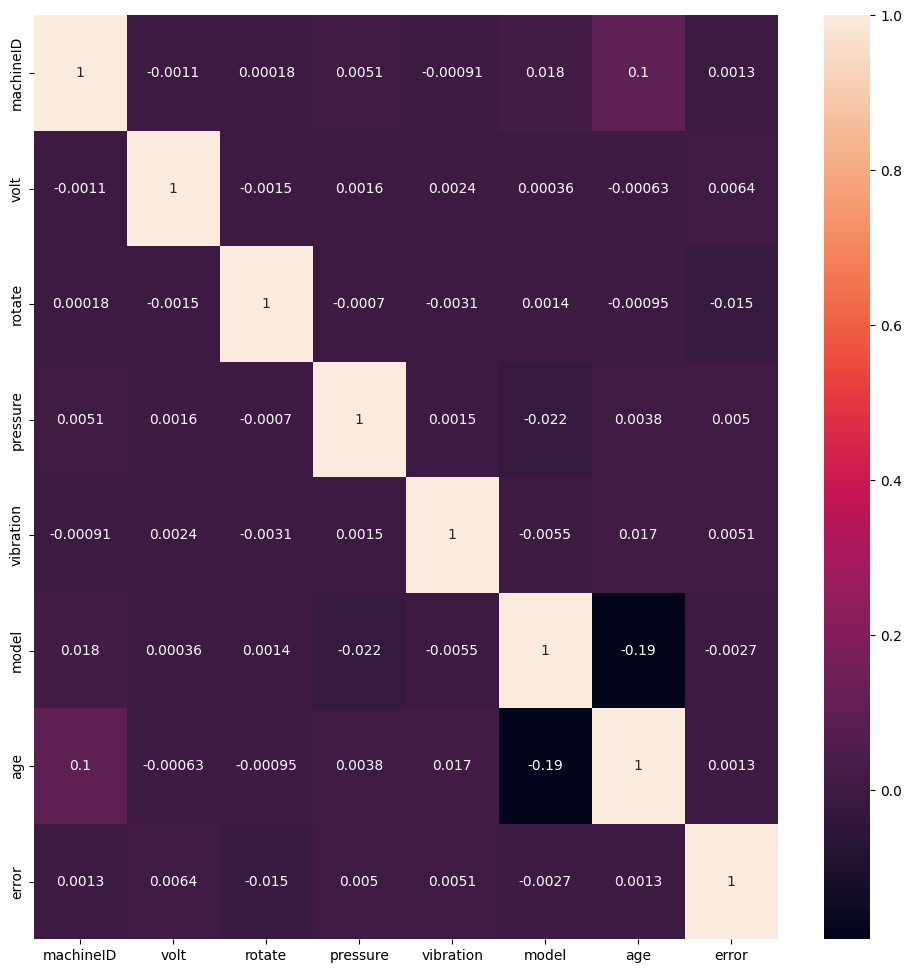

In [ ]:
# Maintenance heatmap

plt.figure(figsize=(12,12))
sns.heatmap(error_full_dataset_logic.corr(),annot=True);
plt.show()

In [ ]:
# Failure heatmap dataframe
from sklearn.preprocessing import LabelEncoder

# We want to analyse if the error exists or not so, we gonna change the error ID for has error
failures_full_dataset['failures'] = np.where(failures_full_dataset['failure'].notnull(), 1, 0)
failures_full_dataset_logic = failures_full_dataset.drop('failure',axis =1)


# Initialize the LabelEncoder
le = LabelEncoder()

# Identify the string columns
string_cols = [col for col in failures_full_dataset_logic.columns if failures_full_dataset_logic[col].dtype == 'object']

# Initialize the LabelEncoder
le = LabelEncoder()

# Loop through each string column in the dataframe and encode the values
for column in string_cols:
    failures_full_dataset_logic[column] = le.fit_transform(failures_full_dataset_logic[column])
failures_full_dataset_logic

,datetime,machineID,volt,rotate,pressure,vibration,month_year,model,age,failures
0,2020-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,2020-01,2,18,0
1,2020-01-01 06:00:00,2,176.558913,424.624162,76.005332,43.767049,2020-01,3,7,0
2,2020-01-01 06:00:00,3,185.482043,461.211137,87.453199,28.216864,2020-01,2,8,0
3,2020-01-01 06:00:00,4,169.710847,463.646727,95.929877,38.400372,2020-01,2,7,0
4,2020-01-01 06:00:00,5,165.082899,452.283576,84.591722,40.298803,2020-01,2,2,0
...,...,...,...,...,...,...,...,...,...,...
876137,2021-01-01 06:00:00,96,157.157424,380.691266,102.885777,35.445739,2021-01,1,10,0
876138,2021-01-01 06:00:00,97,159.607756,458.143799,100.945230,40.011599,2021-01,1,14,0
876139,2021-01-01 06:00:00,98,165.717790,501.520194,114.553412,37.696504,2021-01,1,20,0
876140,2021-01-01 06:00:00,99,168.439623,427.990029,107.899979,44.193151,2021-01,0,14,0


C:\Users\airto\AppData\Local\Temp\ipykernel_7820\534522654.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(failures_full_dataset_logic.corr(),annot=True);


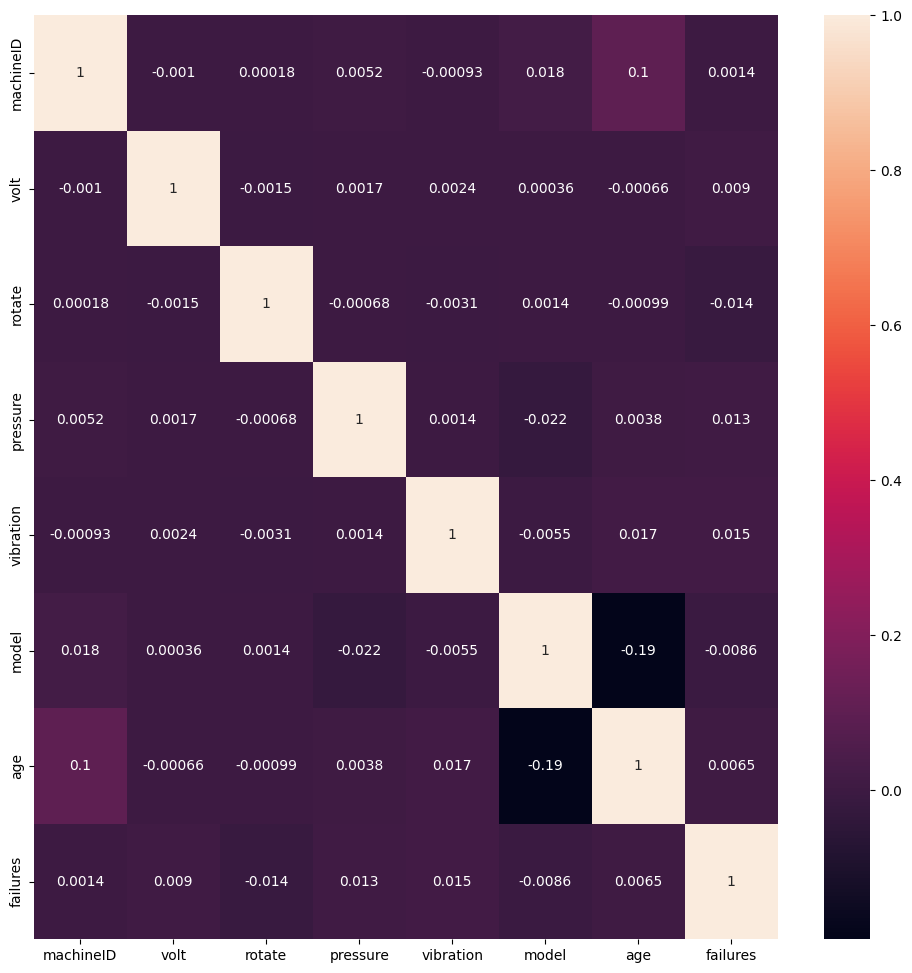

In [ ]:
# Failure heatmap

plt.figure(figsize=(12,12))
sns.heatmap(failures_full_dataset_logic.corr(),annot=True);
plt.show()

C:\Users\airto\AppData\Local\Temp\ipykernel_7820\2840446532.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  failures = failures_errors[failures_errors['failures'] == 1][failures_errors['machineID'] == 1]
C:\Users\airto\AppData\Local\Temp\ipykernel_7820\2840446532.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  errors = failures_errors[failures_errors['errors'] == 1][failures_errors['machineID'] == 1]


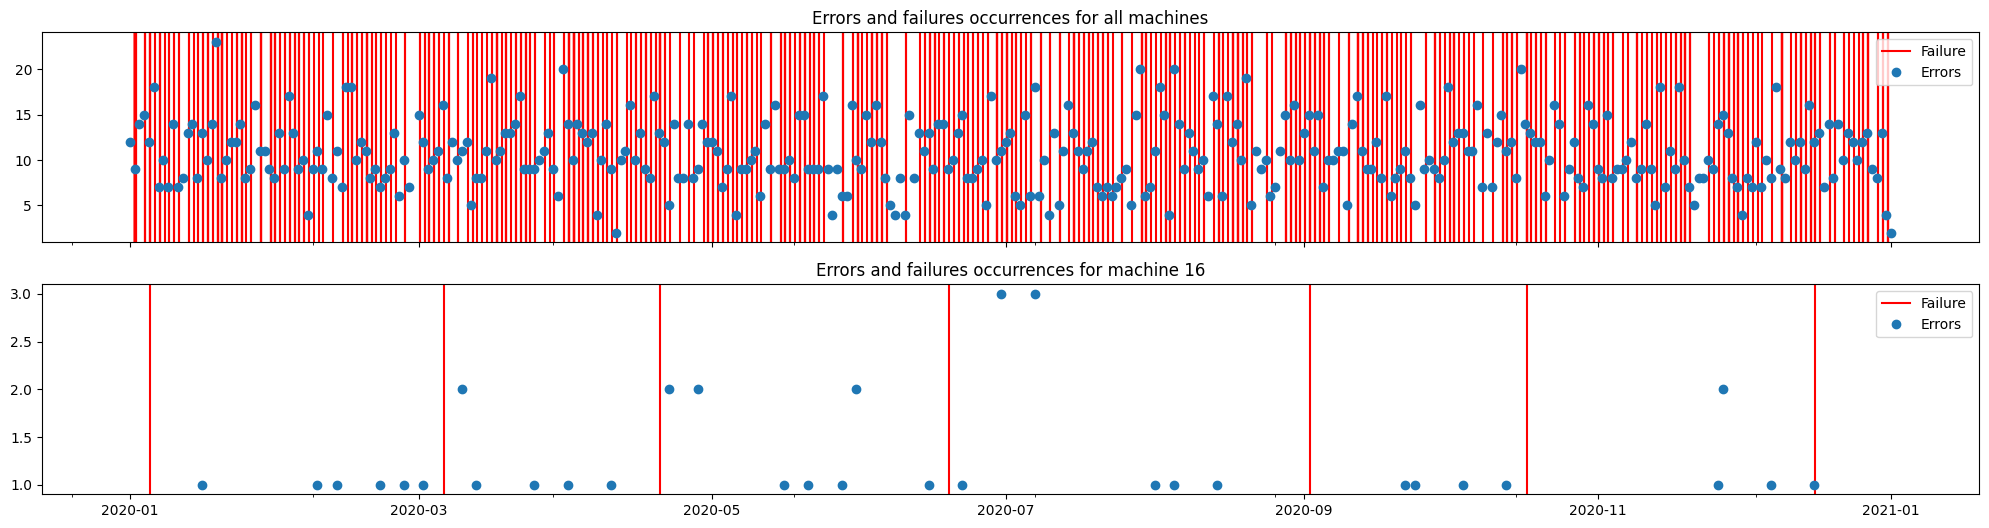

In [ ]:
# Analyzing the errors ocurred before the failure

# Preparing the dataframe
# Creating that ensembles machine data, telemetry, failures and errors occurrences
failures_full_dataset = pd.merge(telemetry_machine_data ,df_failures, how='left', on=["datetime","machineID"])
failures_errors =pd.merge(failures_full_dataset ,df_errors, how='left', on=["datetime","machineID"])
failures_errors['errors'] = np.where(failures_errors['errorID'].notnull(), 1, 0)
failures_errors['failures'] = np.where(failures_errors['failure'].notnull(), 1, 0)
failures_errors.drop(['month_year','model','age','failure','errorID'], axis =1, inplace = True)

# Creating a subplot
fig, axs = plt.subplots(nrows=2, figsize=(25,6), sharex=True)


# Select line with failures
failures = failures_errors[failures_errors['failures'] == 1]
errors = failures_errors[failures_errors['errors'] == 1]

# Plot all machines
plt.sca(axs[0])
plt.axvline(x=failures['datetime'].iloc[0], color='red', label='Failure')
for i in range(1, len(failures)):
    plt.axvline(x=failures['datetime'].iloc[i], color='red')
df_errors['datetime'].dt.date.value_counts().plot(label="Errors", marker='o', linewidth=0)
plt.legend()
plt.title('Errors and failures occurrences for all machines')

# Plotting the errors before the failure for specific machine

# Select line with failures
failures = failures_errors[failures_errors['failures'] == 1][failures_errors['machineID'] == 1]
errors = failures_errors[failures_errors['errors'] == 1][failures_errors['machineID'] == 1]

# Plot only selected machine
plt.sca(axs[1])
plt.axvline(x=failures['datetime'].iloc[0], color='red', label='Failure')
for i in range(1, len(failures)):
    plt.axvline(x=failures['datetime'].iloc[i], color='red')

df_errors[df_errors['machineID']==mac_ID]['datetime'].dt.date.value_counts().plot(label=f"Errors", marker='o', linewidth=0)

plt.legend()

plt.title(f'Errors and failures occurrences for machine {mac_ID}')
plt.show()





C:\Users\airto\AppData\Local\Temp\ipykernel_7820\1843894485.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  failures = failures_maintenance[failures_maintenance['failures'] == 1][failures_maintenance['machineID'] == 1]
C:\Users\airto\AppData\Local\Temp\ipykernel_7820\1843894485.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  maintenance = failures_maintenance[failures_maintenance['maintenances'] == 1][failures_maintenance['machineID'] == 1]


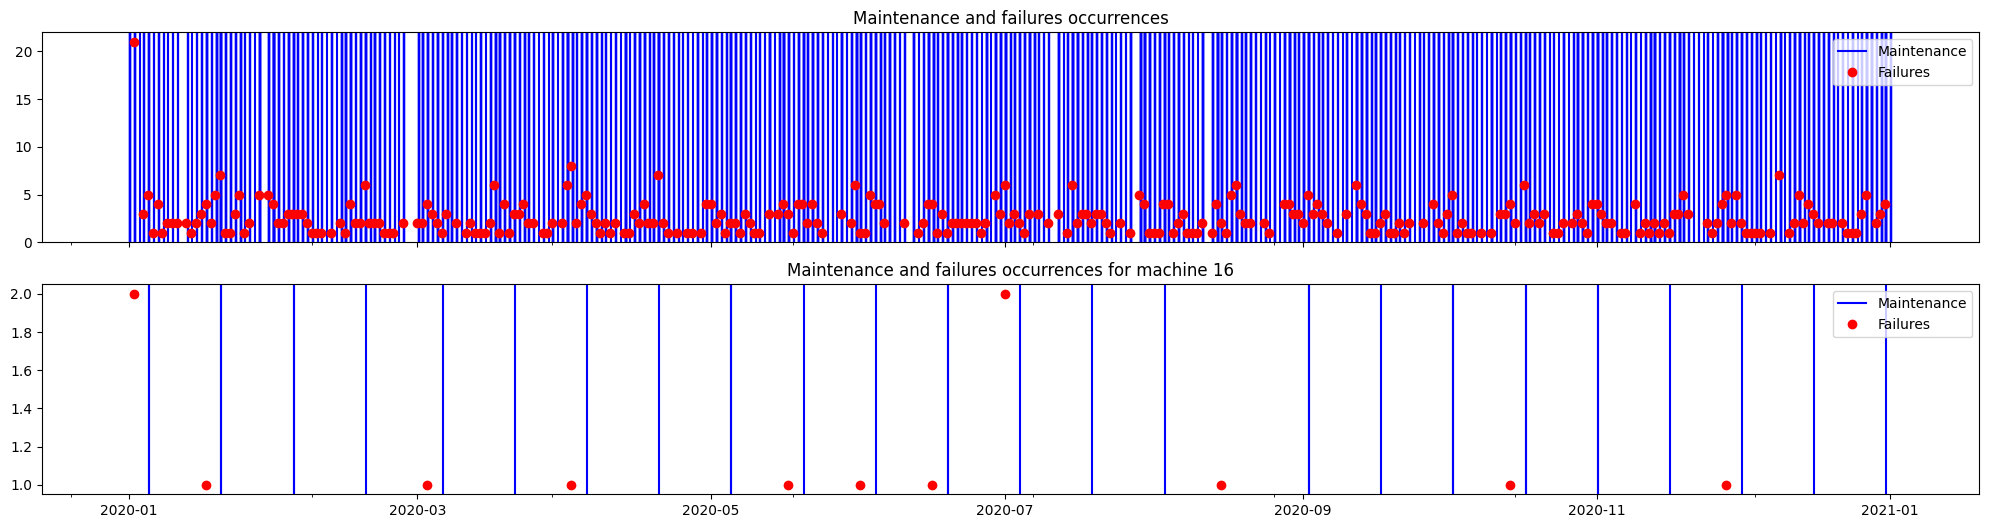

In [ ]:
# Analyzing the failures ocurred after the maintenance

# Preparing the dataframe
# Creating that ensembles machine data, telemetry, failures and errors occurrences
failures_full_dataset = pd.merge(telemetry_machine_data ,df_failures, how='left', on=["datetime","machineID"])
failures_maintenance =pd.merge(failures_full_dataset ,df_maintenance, how='left', on=["datetime","machineID"])
failures_maintenance['maintenances'] = np.where(failures_maintenance['comp'].notnull(), 1, 0)
failures_maintenance['failures'] = np.where(failures_maintenance['failure'].notnull(), 1, 0)
failures_maintenance.drop(['month_year','model','age','failure','comp'], axis =1, inplace = True)


# Creating a subplot
fig, axs = plt.subplots(nrows=2, figsize=(25,6), sharex=True)

# Select line with failures
failures = failures_maintenance[failures_maintenance['failures'] == 1]
maintenance = failures_maintenance[failures_maintenance['maintenances'] == 1]

# Plot for all machines
plt.sca(axs[0])

plt.axvline(x=maintenance['datetime'].iloc[0], color='blue', label='Maintenance')
for i in range(1, len(maintenance)):
    plt.axvline(x=maintenance['datetime'].iloc[i], color='blue')

df_failures['datetime'].dt.date.value_counts().plot(label="Failures", marker='o', color = "red", linewidth=0)

plt.legend(loc="upper right")
plt.title('Maintenance and failures occurrences')


# Select line with failures
failures = failures_maintenance[failures_maintenance['failures'] == 1][failures_maintenance['machineID'] == 1]
maintenance = failures_maintenance[failures_maintenance['maintenances'] == 1][failures_maintenance['machineID'] == 1]

# Plot for specific machine
plt.sca(axs[1])

plt.axvline(x=maintenance['datetime'].iloc[0], color='blue', label='Maintenance')
for i in range(1, len(maintenance)):
    plt.axvline(x=maintenance['datetime'].iloc[i], color='blue')

df_failures[df_failures['machineID']==mac_ID]['datetime'].dt.date.value_counts().plot(label=f"Failures", marker='o', color = "red", linewidth=0)

plt.legend(loc="upper right")
plt.title(f'Maintenance and failures occurrences for machine {mac_ID}')
plt.show()

### Creating a dataset for machine learning prediction

In [ ]:
# The goal of this case study is to build a predictive model that a machine will fail in the next 12 hours due to a certain component failure (component 1, 2, 3, or 4) or not.

def preditive_dataset_12h(df_telemetry, df_errors, df_maintenance, df_failures, df_machines):
    # Read the datasets and create a dataset for analysis to build a predictive model that a machine will fail in the next 12 hours
    
    # Creating variables for each dataset
    telemetry = (df_telemetry)
    errors = (df_errors)
    maint = (df_maintenance)
    failures = (df_failures)
    machines = (df_machines)

    # Formating fields.
    telemetry['datetime'] = pd.to_datetime(telemetry['datetime'], format="%Y-%m-%d %H:%M:%S")

    errors['datetime'] = pd.to_datetime(errors['datetime'], format="%Y-%m-%d %H:%M:%S")
    errors['errorID'] = errors['errorID'].astype('category')

    maint['datetime'] = pd.to_datetime(maint['datetime'], format="%Y-%m-%d %H:%M:%S")
    maint['comp'] = maint['comp'].astype('category')

    machines['model'] = machines['model'].astype('category')

    failures['datetime'] = pd.to_datetime(failures['datetime'], format="%Y-%m-%d %H:%M:%S")
    failures['failure'] = failures['failure'].astype('category')


    ## Lag features for telemetry
    # Capturing 3 hours effect

    # Calculate "resample min values" over the last 3 hour lag window for telemetry features.
    temp = []
    fields = ['volt', 'rotate', 'pressure', 'vibration']
    # Create a table that calculate the min value of each field for each machine for each timestamp
    for col in fields:
        temp.append(pd.pivot_table(telemetry,
                                    index='datetime',
                                    columns='machineID',
                            values=col).resample('3H', closed='left', label='right').min().unstack()) # Group the values in 3 hours interval and turn into dataframe to temp

    telemetry_min_3h = pd.concat(temp, axis=1) # Concatenate all dataframe in the temp list
    telemetry_min_3h.columns = [i + '_min_3h' for i in fields]
    telemetry_min_3h.reset_index(inplace=True)

    # Calculate "resample max values" over the last 3 hour lag window for telemetry features.
    temp = []
    fields = ['volt', 'rotate', 'pressure', 'vibration']
    # Create a table that calculate the max value of each field for each machine for each timestamp
    for col in fields:
        temp.append(pd.pivot_table(telemetry,
                                    index='datetime',
                                    columns='machineID',
                            values=col).resample('3H', closed='left', label='right').max().unstack()) # Group the values in 3 hours interval and turn into dataframe to temp

    telemetry_max_3h = pd.concat(temp, axis=1) # Concatenate all dataframe in the temp list
    telemetry_max_3h.columns = [i + '_max_3h' for i in fields]
    telemetry_max_3h.reset_index(inplace=True)

    # Calculate "resample mean values" over the last 3 hour lag window for telemetry features.
    temp = []
    fields = ['volt', 'rotate', 'pressure', 'vibration']
    # Create a table that calculate the mean value of each field for each machine for each timestamp
    for col in fields:
        temp.append(pd.pivot_table(telemetry,
                                    index='datetime',
                                    columns='machineID',
                            values=col).resample('3H', closed='left', label='right').mean().unstack()) # Group the values in 3 hours interval and turn into dataframe to temp

    telemetry_mean_3h = pd.concat(temp, axis=1) # Concatenate all dataframe in the temp list
    telemetry_mean_3h.columns = [i + '_mean_3h' for i in fields]
    telemetry_mean_3h.reset_index(inplace=True)

    # Calculate "resample standard deviation" over the last 3 hour lag window for telemetry features.
    temp = []
    fields = ['volt', 'rotate', 'pressure', 'vibration']
    # Create a table that calculate the std value of each field for each machine for each timestamp
    for col in fields:
        temp.append(pd.pivot_table(telemetry,
                                    index='datetime',
                                    columns='machineID',
                            values=col).resample('3H', closed='left', label='right').std().unstack()) # Group the values in 3 hours interval and turn into dataframe to temp

    telemetry_sd_3h = pd.concat(temp, axis=1) # Concatenate all dataframe in the temp list
    telemetry_sd_3h.columns = [i + '_sd_3h' for i in fields]
    telemetry_sd_3h.reset_index(inplace=True)

    # Capturing 24 hours effects

    #Calculate "rolling min" over the last 24 hour lag window for telemetry features
    temp = []
    fields = ['volt', 'rotate', 'pressure', 'vibration']
    for col in fields:
            temp.append(pd.pivot_table(telemetry,  index='datetime',
                                                columns='machineID',
                                        values=col).rolling(window=24,center=False).min().resample('3H',
                                                                        closed='left', 
                                                                    label='right').first().unstack())                                                                                

            
    telemetry_min_24h = pd.concat(temp, axis=1)       
    telemetry_min_24h.columns = [i + '_min_24h' for i in fields]
    telemetry_min_24h.reset_index(inplace=True)
    telemetry_min_24h = telemetry_min_24h.loc[-telemetry_min_24h['volt_min_24h'].isnull()]

    #Calculate "rolling max" over the last 24 hour lag window for telemetry features.
    temp = []
    fields = ['volt', 'rotate', 'pressure', 'vibration']
    for col in fields:
            temp.append(pd.pivot_table(telemetry,  index='datetime',
                                                columns='machineID',
                                    values=col).rolling(window=24,center=False).max().resample('3H', 
                                                                                        closed='left', 
                                                                        label='right').first().unstack())                                                                                

            
    telemetry_max_24h = pd.concat(temp, axis=1)       
    telemetry_max_24h.columns = [i + '_max_24h' for i in fields]
    telemetry_max_24h.reset_index(inplace=True)
    telemetry_max_24h = telemetry_max_24h.loc[-telemetry_max_24h['volt_max_24h'].isnull()]

    #Calculate "rolling mean" over the last 24 hour lag window for telemetry features.
    temp = []
    fields = ['volt', 'rotate', 'pressure', 'vibration']
    for col in fields:
            temp.append(pd.pivot_table(telemetry,  index='datetime',
                                                columns='machineID',
                                        values=col).rolling(window=24,center=False).mean().resample('3H',
                                                                                    closed='left', 
                                                                label='right').first().unstack())                                                                                

            
    telemetry_mean_24h = pd.concat(temp, axis=1)       
    telemetry_mean_24h.columns = [i + '_mean_24h' for i in fields]
    telemetry_mean_24h.reset_index(inplace=True)
    telemetry_mean_24h = telemetry_mean_24h.loc[-telemetry_mean_24h['volt_mean_24h'].isnull()]

    #Calculate "rolling standard deviation" over the last 24 hour lag window for telemetry features.
    temp = []
    fields = ['volt', 'rotate', 'pressure', 'vibration']
    for col in fields:
            temp.append(pd.pivot_table(telemetry,  index='datetime',
                                                columns='machineID',
                                values=col).rolling(window=24,center=False).std().resample('3H', 
                                                    closed='left', label='right').first().unstack())   

    telemetry_sd_24h = pd.concat(temp, axis=1)
    telemetry_sd_24h.columns = [i + '_sd_24h' for i in fields]
    telemetry_sd_24h.reset_index(inplace=True)
    telemetry_sd_24h = telemetry_sd_24h.loc[-telemetry_sd_24h['volt_sd_24h'].isnull()]


    # Merge columns of feature sets created earlier
    telemetry_feat = pd.concat([telemetry_min_3h,
                                telemetry_max_3h.iloc[:, 2:6], # Exclude columns datetime and machineID to not repeat
                                telemetry_mean_3h.iloc[:, 2:6],
                                telemetry_sd_3h.iloc[:, 2:6],
                                telemetry_min_24h.iloc[:, 2:6],
                                telemetry_max_24h.iloc[:, 2:6],
                                telemetry_mean_24h.iloc[:, 2:6],
                                telemetry_sd_24h.iloc[:, 2:6]], axis=1).dropna()


    ## Lag features for errors

    # Create a column for each error type
    error_count = pd.get_dummies(errors.set_index('datetime')).reset_index()
    error_count.columns = ['datetime', 'machineID', 'error1', 'error2', 'error3', 'error4', 'error5']
    # Combine errors for a given machine in a given hour
    error_count = error_count.groupby(['machineID', 'datetime']).sum().reset_index()
    # Merge on telemetry dataset
    error_count = telemetry[['datetime', 'machineID']].merge(error_count, on=['machineID', 'datetime'], 
                                                                how='left').fillna(0.0)

    # Compute the total number of errors of each type over the last 24 hours, for point taken every 3 hours
    temp = []
    fields = ['error%d' % i for i in range(1,6)]
    for col in fields:
        temp.append(pd.pivot_table(error_count,
                                                index='datetime',
                                                columns='machineID',
                                            values=col).rolling(window=24).sum().resample('3H', 
                                                        closed='left', label='right').first().unstack())


    error_count = pd.concat(temp, axis=1)
    error_count.columns = [i + 'count' for i in fields]
    # error_count.reset_index(inplace=True)#To be activate
    error_count = error_count.dropna()


    # Count the number of the days since last replacement of component from maintenance

    # Create a column for each component that was replaced
    comp_rep = pd.get_dummies(maint.set_index('datetime')).reset_index()
    comp_rep.columns = ['datetime', 'machineID', 'comp1', 'comp2', 'comp3', 'comp4']

    # Combine repairs for a given machine in a given hour
    comp_rep = comp_rep.groupby(['machineID', 'datetime']).sum().reset_index()

    # Add timepoints where no components were replaced
    comp_rep = telemetry[['datetime', 'machineID']].merge(comp_rep,
                                                        on=['datetime', 'machineID'],
                                        how='outer').fillna(0).sort_values(by=['machineID', 'datetime'])


    components = ['comp1', 'comp2', 'comp3', 'comp4']
    for comp in tqdm_notebook(components):
        # Convert indicator to most recent date of component change
        comp_rep.loc[comp_rep[comp] < 1, comp] = None
        comp_rep.loc[-comp_rep[comp].isnull(), comp] = comp_rep.loc[-comp_rep[comp].isnull(),'datetime']
        
        # Forward-fill the most-recent date of component change
        comp_rep[comp] = comp_rep[comp].fillna(method='ffill')

    # Remove dates in 2014 (may have NaN or future component change dates)    
    comp_rep = comp_rep.loc[comp_rep['datetime'] > pd.to_datetime('2015-01-01')]

    # Replace dates of most recent component change with days since most recent component change
    for comp in tqdm_notebook(components):
        comp_rep[comp] = (comp_rep['datetime'] - comp_rep[comp]) / np.timedelta64(1, 'D')


    # Creating the final features for prediction
    final_feat = telemetry_feat.merge(error_count, on=['datetime', 'machineID'], how='left') # Merging errors
    final_feat = final_feat.merge(comp_rep, on=['datetime', 'machineID'], how='left') # Merging components replacements
    final_feat = final_feat.merge(machines, on=['machineID'], how='left') # Merging machine data


    # Label construction
    # The goal is to predict that a machine will fail in the next 24 hours due to a certain component failure (component 1, 2, 3, or 4) or not -> label = failure (none to no failure, and comp that failed)
    labeled_features = final_feat.merge(failures, on=['datetime', 'machineID'], how='left')
    labeled_features = labeled_features.fillna(method='bfill', limit=7) # fill backward up to 24h
    labeled_features['failure'] = labeled_features['failure'].astype('str')
    labeled_features.replace({'nan': "none"}, inplace= True)
    return labeled_features

In [ ]:
# The goal of this case study is to build a predictive model that a machine will fail in the next 24 hours due to a certain component failure (component 1, 2, 3, or 4) or not.

def preditive_dataset_24h(df_telemetry, df_errors, df_maintenance, df_failures, df_machines):
    # Read the datasets and create a dataset for analysis to build a predictive model that a machine will fail in the next 24 hours
    
    # Creating variables for each dataset
    telemetry = (df_telemetry)
    errors = (df_errors)
    maint = (df_maintenance)
    failures = (df_failures)
    machines = (df_machines)

    # Formating fields.
    telemetry['datetime'] = pd.to_datetime(telemetry['datetime'], format="%Y-%m-%d %H:%M:%S")

    errors['datetime'] = pd.to_datetime(errors['datetime'], format="%Y-%m-%d %H:%M:%S")
    errors['errorID'] = errors['errorID'].astype('category')

    maint['datetime'] = pd.to_datetime(maint['datetime'], format="%Y-%m-%d %H:%M:%S")
    maint['comp'] = maint['comp'].astype('category')

    machines['model'] = machines['model'].astype('category')

    failures['datetime'] = pd.to_datetime(failures['datetime'], format="%Y-%m-%d %H:%M:%S")
    failures['failure'] = failures['failure'].astype('category')


    ## Lag features for telemetry
    # Capturing 3 hours effect

    # Calculate "resample min values" over the last 3 hour lag window for telemetry features.
    temp = []
    fields = ['volt', 'rotate', 'pressure', 'vibration']
    # Create a table that calculate the min value of each field for each machine for each timestamp
    for col in fields:
        temp.append(pd.pivot_table(telemetry,
                                    index='datetime',
                                    columns='machineID',
                            values=col).resample('3H', closed='left', label='right').min().unstack()) # Group the values in 3 hours interval and turn into dataframe to temp

    telemetry_min_3h = pd.concat(temp, axis=1) # Concatenate all dataframe in the temp list
    telemetry_min_3h.columns = [i + '_min_3h' for i in fields]
    telemetry_min_3h.reset_index(inplace=True)

    # Calculate "resample max values" over the last 3 hour lag window for telemetry features.
    temp = []
    fields = ['volt', 'rotate', 'pressure', 'vibration']
    # Create a table that calculate the max value of each field for each machine for each timestamp
    for col in fields:
        temp.append(pd.pivot_table(telemetry,
                                    index='datetime',
                                    columns='machineID',
                            values=col).resample('3H', closed='left', label='right').max().unstack()) # Group the values in 3 hours interval and turn into dataframe to temp

    telemetry_max_3h = pd.concat(temp, axis=1) # Concatenate all dataframe in the temp list
    telemetry_max_3h.columns = [i + '_max_3h' for i in fields]
    telemetry_max_3h.reset_index(inplace=True)

    # Calculate "resample mean values" over the last 3 hour lag window for telemetry features.
    temp = []
    fields = ['volt', 'rotate', 'pressure', 'vibration']
    # Create a table that calculate the mean value of each field for each machine for each timestamp
    for col in fields:
        temp.append(pd.pivot_table(telemetry,
                                    index='datetime',
                                    columns='machineID',
                            values=col).resample('3H', closed='left', label='right').mean().unstack()) # Group the values in 3 hours interval and turn into dataframe to temp

    telemetry_mean_3h = pd.concat(temp, axis=1) # Concatenate all dataframe in the temp list
    telemetry_mean_3h.columns = [i + '_mean_3h' for i in fields]
    telemetry_mean_3h.reset_index(inplace=True)

    # Calculate "resample standard deviation" over the last 3 hour lag window for telemetry features.
    temp = []
    fields = ['volt', 'rotate', 'pressure', 'vibration']
    # Create a table that calculate the std value of each field for each machine for each timestamp
    for col in fields:
        temp.append(pd.pivot_table(telemetry,
                                    index='datetime',
                                    columns='machineID',
                            values=col).resample('3H', closed='left', label='right').std().unstack()) # Group the values in 3 hours interval and turn into dataframe to temp

    telemetry_sd_3h = pd.concat(temp, axis=1) # Concatenate all dataframe in the temp list
    telemetry_sd_3h.columns = [i + '_sd_3h' for i in fields]
    telemetry_sd_3h.reset_index(inplace=True)

    # Capturing 24 hours effects

    #Calculate "rolling min" over the last 24 hour lag window for telemetry features
    temp = []
    fields = ['volt', 'rotate', 'pressure', 'vibration']
    for col in fields:
            temp.append(pd.pivot_table(telemetry,  index='datetime',
                                                columns='machineID',
                                        values=col).rolling(window=24,center=False).min().resample('3H',
                                                                        closed='left', 
                                                                    label='right').first().unstack())                                                                                

            
    telemetry_min_24h = pd.concat(temp, axis=1)       
    telemetry_min_24h.columns = [i + '_min_24h' for i in fields]
    telemetry_min_24h.reset_index(inplace=True)
    telemetry_min_24h = telemetry_min_24h.loc[-telemetry_min_24h['volt_min_24h'].isnull()]

    #Calculate "rolling max" over the last 24 hour lag window for telemetry features.
    temp = []
    fields = ['volt', 'rotate', 'pressure', 'vibration']
    for col in fields:
            temp.append(pd.pivot_table(telemetry,  index='datetime',
                                                columns='machineID',
                                    values=col).rolling(window=24,center=False).max().resample('3H', 
                                                                                        closed='left', 
                                                                        label='right').first().unstack())                                                                                

            
    telemetry_max_24h = pd.concat(temp, axis=1)       
    telemetry_max_24h.columns = [i + '_max_24h' for i in fields]
    telemetry_max_24h.reset_index(inplace=True)
    telemetry_max_24h = telemetry_max_24h.loc[-telemetry_max_24h['volt_max_24h'].isnull()]

    #Calculate "rolling mean" over the last 24 hour lag window for telemetry features.
    temp = []
    fields = ['volt', 'rotate', 'pressure', 'vibration']
    for col in fields:
            temp.append(pd.pivot_table(telemetry,  index='datetime',
                                                columns='machineID',
                                        values=col).rolling(window=24,center=False).mean().resample('3H',
                                                                                    closed='left', 
                                                                label='right').first().unstack())                                                                                

            
    telemetry_mean_24h = pd.concat(temp, axis=1)       
    telemetry_mean_24h.columns = [i + '_mean_24h' for i in fields]
    telemetry_mean_24h.reset_index(inplace=True)
    telemetry_mean_24h = telemetry_mean_24h.loc[-telemetry_mean_24h['volt_mean_24h'].isnull()]

    #Calculate "rolling standard deviation" over the last 24 hour lag window for telemetry features.
    temp = []
    fields = ['volt', 'rotate', 'pressure', 'vibration']
    for col in fields:
            temp.append(pd.pivot_table(telemetry,  index='datetime',
                                                columns='machineID',
                                values=col).rolling(window=24,center=False).std().resample('3H', 
                                                    closed='left', label='right').first().unstack())   

    telemetry_sd_24h = pd.concat(temp, axis=1)
    telemetry_sd_24h.columns = [i + '_sd_24h' for i in fields]
    telemetry_sd_24h.reset_index(inplace=True)
    telemetry_sd_24h = telemetry_sd_24h.loc[-telemetry_sd_24h['volt_sd_24h'].isnull()]


    # Merge columns of feature sets created earlier
    telemetry_feat = pd.concat([telemetry_min_3h,
                                telemetry_max_3h.iloc[:, 2:6], # Exclude columns datetime and machineID to not repeat
                                telemetry_mean_3h.iloc[:, 2:6],
                                telemetry_sd_3h.iloc[:, 2:6],
                                telemetry_min_24h.iloc[:, 2:6],
                                telemetry_max_24h.iloc[:, 2:6],
                                telemetry_mean_24h.iloc[:, 2:6],
                                telemetry_sd_24h.iloc[:, 2:6]], axis=1).dropna()


    ## Lag features for errors

    # Create a column for each error type
    error_count = pd.get_dummies(errors.set_index('datetime')).reset_index()
    error_count.columns = ['datetime', 'machineID', 'error1', 'error2', 'error3', 'error4', 'error5']
    # Combine errors for a given machine in a given hour
    error_count = error_count.groupby(['machineID', 'datetime']).sum().reset_index()
    # Merge on telemetry dataset
    error_count = telemetry[['datetime', 'machineID']].merge(error_count, on=['machineID', 'datetime'], 
                                                                how='left').fillna(0.0)

    # Compute the total number of errors of each type over the last 24 hours, for point taken every 3 hours
    temp = []
    fields = ['error%d' % i for i in range(1,6)]
    for col in fields:
        temp.append(pd.pivot_table(error_count,
                                                index='datetime',
                                                columns='machineID',
                                            values=col).rolling(window=24).sum().resample('3H', 
                                                        closed='left', label='right').first().unstack())


    error_count = pd.concat(temp, axis=1)
    error_count.columns = [i + 'count' for i in fields]
    # error_count.reset_index(inplace=True)#To be activate
    error_count = error_count.dropna()


    # Count the number of the days since last replacement of component from maintenance

    # Create a column for each component that was replaced
    comp_rep = pd.get_dummies(maint.set_index('datetime')).reset_index()
    comp_rep.columns = ['datetime', 'machineID', 'comp1', 'comp2', 'comp3', 'comp4']

    # Combine repairs for a given machine in a given hour
    comp_rep = comp_rep.groupby(['machineID', 'datetime']).sum().reset_index()

    # Add timepoints where no components were replaced
    comp_rep = telemetry[['datetime', 'machineID']].merge(comp_rep,
                                                        on=['datetime', 'machineID'],
                                        how='outer').fillna(0).sort_values(by=['machineID', 'datetime'])


    components = ['comp1', 'comp2', 'comp3', 'comp4']
    for comp in tqdm_notebook(components):
        # Convert indicator to most recent date of component change
        comp_rep.loc[comp_rep[comp] < 1, comp] = None
        comp_rep.loc[-comp_rep[comp].isnull(), comp] = comp_rep.loc[-comp_rep[comp].isnull(),'datetime']
        
        # Forward-fill the most-recent date of component change
        comp_rep[comp] = comp_rep[comp].fillna(method='ffill')

    # Remove dates in 2014 (may have NaN or future component change dates)    
    comp_rep = comp_rep.loc[comp_rep['datetime'] > pd.to_datetime('2015-01-01')]

    # Replace dates of most recent component change with days since most recent component change
    for comp in tqdm_notebook(components):
        comp_rep[comp] = (comp_rep['datetime'] - comp_rep[comp]) / np.timedelta64(1, 'D')


    # Creating the final features for prediction
    final_feat = telemetry_feat.merge(error_count, on=['datetime', 'machineID'], how='left') # Merging errors
    final_feat = final_feat.merge(comp_rep, on=['datetime', 'machineID'], how='left') # Merging components replacements
    final_feat = final_feat.merge(machines, on=['machineID'], how='left') # Merging machine data


    # Label construction
    # The goal is to predict that a machine will fail in the next 24 hours due to a certain component failure (component 1, 2, 3, or 4) or not -> label = failure (none to no failure, and comp that failed)
    labeled_features = final_feat.merge(failures, on=['datetime', 'machineID'], how='left')
    labeled_features = labeled_features.fillna(method='bfill', limit=7) # fill backward up to 24h
    labeled_features['failure'] = labeled_features['failure'].astype('str')
    labeled_features.replace({'nan': "none"}, inplace= True)
    return labeled_features

In [ ]:
dataset_12h = preditive_dataset_12h(df_telemetry, df_errors, df_maintenance, df_failures, df_machines)
dataset_12h 

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

,machineID,datetime,volt_min_3h,rotate_min_3h,pressure_min_3h,vibration_min_3h,volt_max_3h,rotate_max_3h,pressure_max_3h,vibration_max_3h,...,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age,failure
0,1,2020-01-02 06:00:00,158.271400,403.235951,92.439132,32.516838,200.872430,495.777958,96.535487,52.355876,...,0.0,0.0,0.0,20.000,215.000,155.000,170.000,model3,18,none
1,1,2020-01-02 09:00:00,160.528861,384.645962,86.944273,29.527665,197.363125,486.459056,114.342061,42.992509,...,0.0,0.0,0.0,20.125,215.125,155.125,170.125,model3,18,none
2,1,2020-01-02 12:00:00,147.300678,412.965696,90.711354,34.203042,173.394523,439.579460,110.408985,37.117103,...,0.0,0.0,0.0,20.250,215.250,155.250,170.250,model3,18,none
3,1,2020-01-02 15:00:00,152.420775,385.354924,99.506819,30.665184,185.205355,497.840620,105.993247,47.862484,...,0.0,0.0,0.0,20.375,215.375,155.375,170.375,model3,18,none
4,1,2020-01-02 18:00:00,145.248486,424.542633,93.743827,37.422272,180.030715,495.376449,111.950587,43.099758,...,0.0,0.0,0.0,20.500,215.500,155.500,170.500,model3,18,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291336,100,2020-12-31 18:00:00,164.729171,388.490938,99.763131,43.916301,191.020128,537.789373,105.847232,50.832210,...,0.0,0.0,0.0,82.500,7.500,82.500,52.500,model4,5,none
291337,100,2020-12-31 21:00:00,138.506098,360.053876,79.584958,27.457001,196.932834,497.861210,112.525039,34.867196,...,0.0,0.0,0.0,82.625,7.625,82.625,52.625,model4,5,none
291338,100,2021-01-01 00:00:00,152.182033,414.011630,99.132955,37.666806,169.397346,552.012586,117.426340,43.966709,...,0.0,0.0,0.0,82.750,7.750,82.750,52.750,model4,5,none
291339,100,2021-01-01 03:00:00,162.742669,395.222827,101.589735,44.382754,179.438162,481.253908,103.158233,50.771941,...,0.0,0.0,0.0,82.875,7.875,82.875,52.875,model4,5,none


In [ ]:
dataset_24h = preditive_dataset_24h(df_telemetry, df_errors, df_maintenance, df_failures, df_machines)
dataset_24h

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

,machineID,datetime,volt_min_3h,rotate_min_3h,pressure_min_3h,vibration_min_3h,volt_max_3h,rotate_max_3h,pressure_max_3h,vibration_max_3h,...,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age,failure
0,1,2020-01-02 06:00:00,158.271400,403.235951,92.439132,32.516838,200.872430,495.777958,96.535487,52.355876,...,0.0,0.0,0.0,20.000,215.000,155.000,170.000,model3,18,none
1,1,2020-01-02 09:00:00,160.528861,384.645962,86.944273,29.527665,197.363125,486.459056,114.342061,42.992509,...,0.0,0.0,0.0,20.125,215.125,155.125,170.125,model3,18,none
2,1,2020-01-02 12:00:00,147.300678,412.965696,90.711354,34.203042,173.394523,439.579460,110.408985,37.117103,...,0.0,0.0,0.0,20.250,215.250,155.250,170.250,model3,18,none
3,1,2020-01-02 15:00:00,152.420775,385.354924,99.506819,30.665184,185.205355,497.840620,105.993247,47.862484,...,0.0,0.0,0.0,20.375,215.375,155.375,170.375,model3,18,none
4,1,2020-01-02 18:00:00,145.248486,424.542633,93.743827,37.422272,180.030715,495.376449,111.950587,43.099758,...,0.0,0.0,0.0,20.500,215.500,155.500,170.500,model3,18,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291336,100,2020-12-31 18:00:00,164.729171,388.490938,99.763131,43.916301,191.020128,537.789373,105.847232,50.832210,...,0.0,0.0,0.0,82.500,7.500,82.500,52.500,model4,5,none
291337,100,2020-12-31 21:00:00,138.506098,360.053876,79.584958,27.457001,196.932834,497.861210,112.525039,34.867196,...,0.0,0.0,0.0,82.625,7.625,82.625,52.625,model4,5,none
291338,100,2021-01-01 00:00:00,152.182033,414.011630,99.132955,37.666806,169.397346,552.012586,117.426340,43.966709,...,0.0,0.0,0.0,82.750,7.750,82.750,52.750,model4,5,none
291339,100,2021-01-01 03:00:00,162.742669,395.222827,101.589735,44.382754,179.438162,481.253908,103.158233,50.771941,...,0.0,0.0,0.0,82.875,7.875,82.875,52.875,model4,5,none


### Conclusion

- ERRORS
    -	Error 1 is the error that most occurs, but it was not present on all machines, error 5 is the only one that occurs on all machines, even if its occurrence is the smallest among all.
    -	The errors are almost equally distributed over the analyzed time series.
    -	The error rate is equal to 0.44716871119793167 %.
    -	MTBE (Mean Time Between Erros) is a metric that measures the average time between two consecutive errors of a machine. Even if the machines present errors, they will continue to work. The average MTBE of this set of machines in the period is: 219.42 hours. Which means that, on average, the machines operate for 219.42 hours without showing errors. The presence of outliers indicates that the MTBE should be used machine-by-machine, not a mean for all.
#
- MAINTENANCE
    -	The components have practically the same number of maintenances, with an average of 821 maintenances, where component 2 is the one with the most maintenance (863). In addition, the only component that underwent maintenance on all machines was component 4.
    -	Maintenance is concentrated after 45% of the time the machines have been used (2886 maintenances), even if a number of errors have occurred previously (409 maintenances).
    -	The maintenance rate is equal to 0.3291428258610951 %.
#
- FAILURES
    -	Component 2 and 4 are components that have a number of failures above the average, where component 2 has a number of failures far above the others.
    -	The failures are almost equally distributed during the analyzed time series.
    -	The failures rate is equal to 0.08685806638649707 %
    -	Mean time between failures (MTBF) is a vital metric in machine maintenance, representing the average time elapsed between two consecutive failures.
    -	Calculated by dividing total operating time by the number of failures experienced, a higher MTBE implies greater reliability, while a lower MTBE signals a machine prone to frequent breakdowns. By evaluating the effectiveness of maintenance practices and identifying areas for improvement, MTBE provides valuable insights for increasing machine uptime and reducing maintenance costs. The average MTBF of this set of machines in the period is: 1087.32 hours. Which means that, on average, the machines operate for 1087.32 hours without showing failures, and stopping. The presence of outliers indicates that the MTBF should be used machine-by-machine, not a mean for all, because, as you can notice, the median (912.83 hours) is far from the mean.
#
- UNIFIED ANALYSIS
    -	It was not possible to find a direct relationship between increasing age and the number of maintenance occurrences, errors or failures.
    -	Observing the heat map for correlation, it was not possible to find a large direct relationship between a single variable and the occurrence of error, maintenance or failure
    -	During a maintenance the machine stops its operation, so to calculate the time between each interruption in its operation. The main reason to stop is maintenance.
    -	The average time between stop is 324.94 hours.
    -	Time without stopping isn't the best way to represents the operational time. Because we don't know the time of maintenance.
    -	It's possible to observe that errors tend to occur before the failures, so it could be a good predictor.
    -	Failures tends to decrease after a replacement in a component, since the longer a component is used, the more degradation should be expected.
    -	The goal of this predictive analysis is to build a predictive model that a machine will fail in the next 12 hours due to a certain component failure (component 1, 2, 3, or 4) or not. So will be created a lag feature for each 3 hours and for each 12 hours.
    -	We count the number of errors of each type in a lagging window. We begin by reformatting the error data to have one entry per machine per time at which at least one error occurred

## Failure prediction for 24 hours window


### Data modelling for prediction


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Creating the dataset
dataset_24h = preditive_dataset_24h(df_telemetry, df_errors, df_maintenance, df_failures, df_machines)

# Splitting into variables and label
# Features
''' Drop datetime to not mislead future dates, time is calculated by amount of error and days after replacement
Drop machineID because their similar characteristics lead to a unique model
Drop failure, because its our label'''

X = dataset_24h.drop(['datetime','machineID','failure'], axis = 1) 

# Initialize the LabelEncoder for model and apply to model
le = LabelEncoder()
Xlabel = X
Xlabel['model'] = le.fit_transform(Xlabel['model'])

# Scale the data
s = StandardScaler()
Xfinal = s.fit_transform(Xlabel)


# Target value
Y = le.fit_transform(dataset_24h['failure'])
# None = 4, Comp1 = 0, Comp2 = 1, Comp3 = 2, Comp4 = 3


# Split test/train
X_train,X_test,y_train,y_test = train_test_split(Xfinal,Y,test_size = 0.20, shuffle = False, random_state = 42)


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# Function to plot confusion matrix
# This function plots the confusion matrices given y_i, y_i_hat.
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    
    labels = ['comp1', 'comp2', 'comp3', 'comp4', 'none']
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show() 

### XGBClassifier

XGBClassifier is a machine learning model based on the gradient boosting algorithm, designed to handle large datasets with high dimensionality. It uses decision trees as base learners and optimizes their weights through gradient descent. XGBClassifier has several advantages over traditional gradient boosting algorithms, such as faster computation and better regularization. It also includes several hyperparameters that can be tuned to optimize its performance on a given task. XGBClassifier has been shown to perform well on a wide range of classification problems, including those with imbalanced datasets or noisy features.

In [122]:
# Applying XGBClassifier on dataset
from xgboost import XGBClassifier

# Create XGBClassifier object
x_cfl = XGBClassifier()

# Fitting the model without defining the best hyperparameters
x_cfl.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       312
           1       0.99      1.00      0.99       434
           2       0.97      1.00      0.98       329
           3       0.98      0.97      0.97       231
           4       1.00      1.00      1.00     56963

    accuracy                           1.00     58269
   macro avg       0.98      0.99      0.98     58269
weighted avg       1.00      1.00      1.00     58269

-------------------- Confusion matrix --------------------


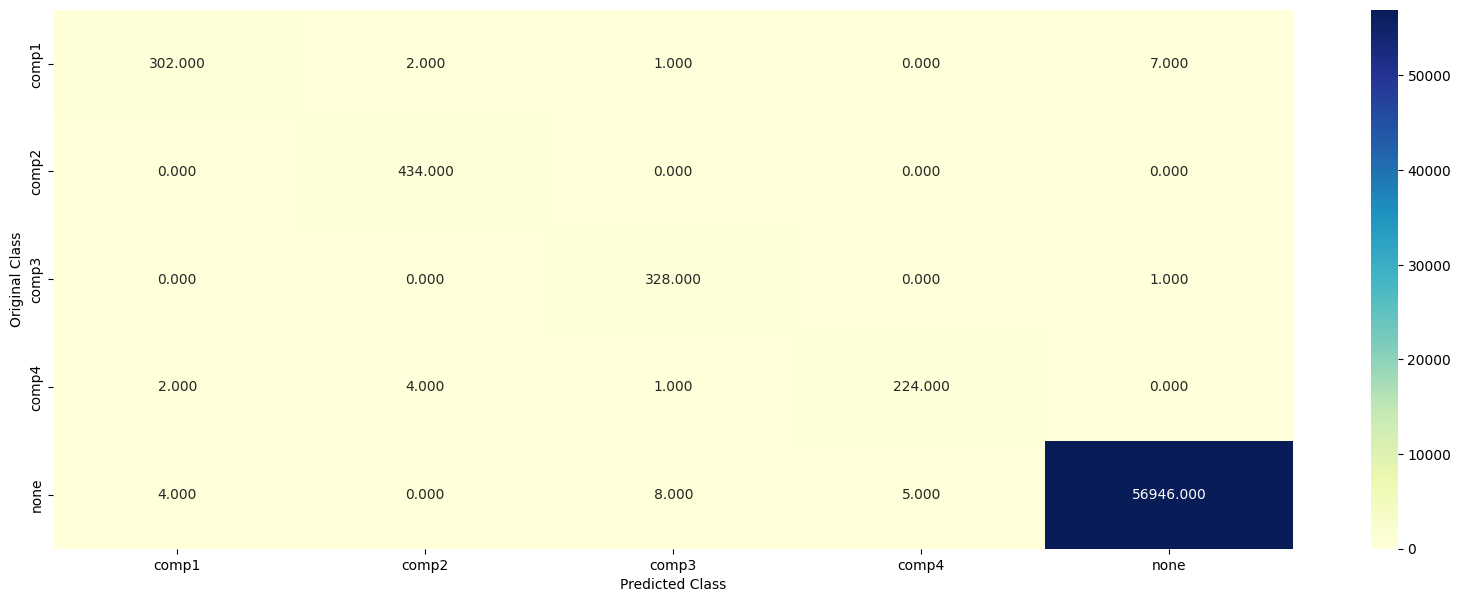

In [123]:
# Make predictions on test set
y_pred = x_cfl.predict(X_test)

# Calculate classification report
report = classification_report(y_test, y_pred)

# Save main results
macro_recall_1 = (classification_report(y_test, y_pred, output_dict = True))

# Print results
print(report)

# Plot confusion matrix
plot_confusion_matrix(y_test, x_cfl.predict(X_test))

### Random Tress Classifier

The random forest classifier is a popular machine learning algorithm used for classification tasks. It works by constructing multiple decision trees and then combining their predictions to make a final prediction. Each tree is built on a randomly sampled subset of the data, and each split in the tree is chosen based on the best split among a random subset of the features. 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create Random Forest Classifier object

RF_clf = RandomForestClassifier(n_estimators=10, random_state=42)
RF_clf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=10, random_state=42)

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       312
           1       0.98      0.99      0.99       434
           2       0.98      0.96      0.97       329
           3       0.97      0.97      0.97       231
           4       1.00      1.00      1.00     56963

    accuracy                           1.00     58269
   macro avg       0.97      0.98      0.98     58269
weighted avg       1.00      1.00      1.00     58269

-------------------- Confusion matrix --------------------


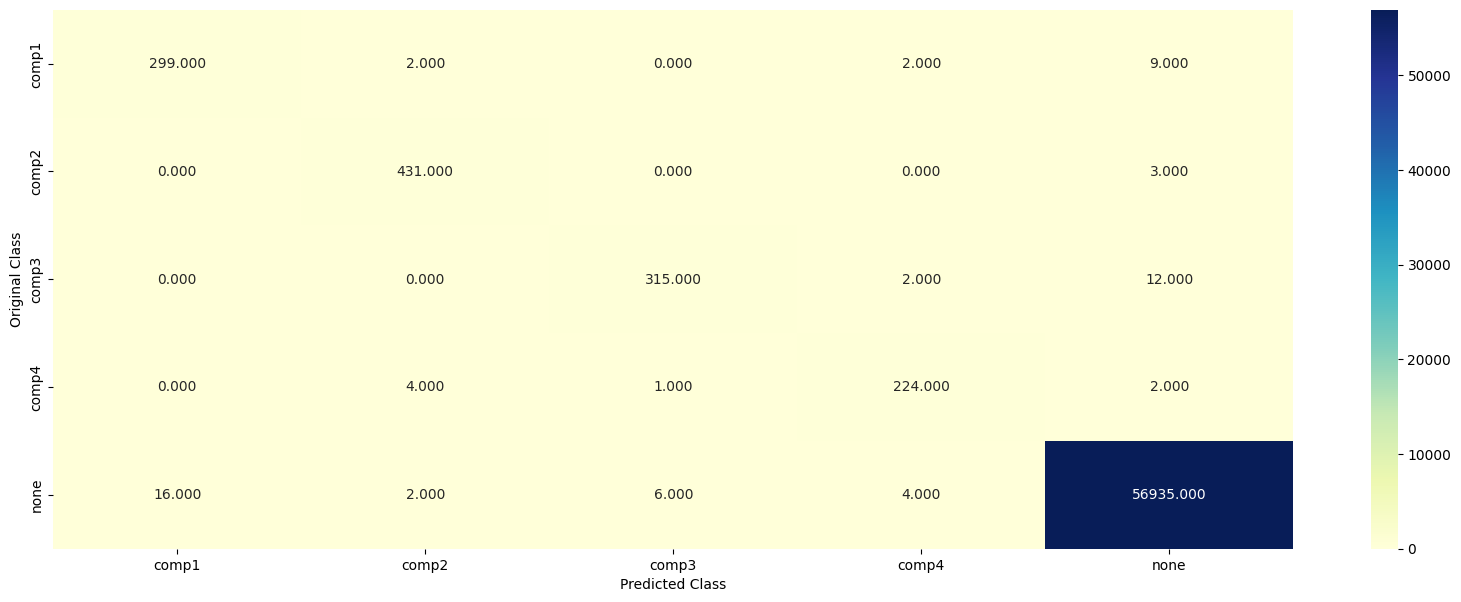

In [ ]:
# Make predictions on test set
y_pred2 = RF_clf.predict(X_test)

# Calculate classification report
report = classification_report(y_test, y_pred2)

# Save main results
macro_recall_2 = (classification_report(y_test, y_pred2, output_dict = True))

# Print results
print(report)

# Plot confusion matrix
plot_confusion_matrix(y_test, RF_clf.predict(X_test))

### Extra Trees Classifier

ExtraTreesClassifier is an ensemble learning method for classification that is similar to random forests. Like random forests, ExtraTreesClassifier also builds multiple decision trees and outputs the class that is the mode of the classes predicted by individual trees. However, ExtraTreesClassifier differs from random forests in two main ways: first, it selects the splits for each tree at random, rather than searching for the best split, and second, it uses the entire dataset for training each tree rather than bootstrapping samples for each tree. 

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

# Create Extra Trees Classifier object

Extra_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
Extra_clf.fit(X_train,y_train)

ExtraTreesClassifier(random_state=42)

              precision    recall  f1-score   support

           0       0.88      0.94      0.91       312
           1       0.99      1.00      0.99       434
           2       0.97      0.99      0.98       329
           3       0.98      0.97      0.97       231
           4       1.00      1.00      1.00     56963

    accuracy                           1.00     58269
   macro avg       0.96      0.98      0.97     58269
weighted avg       1.00      1.00      1.00     58269

-------------------- Confusion matrix --------------------


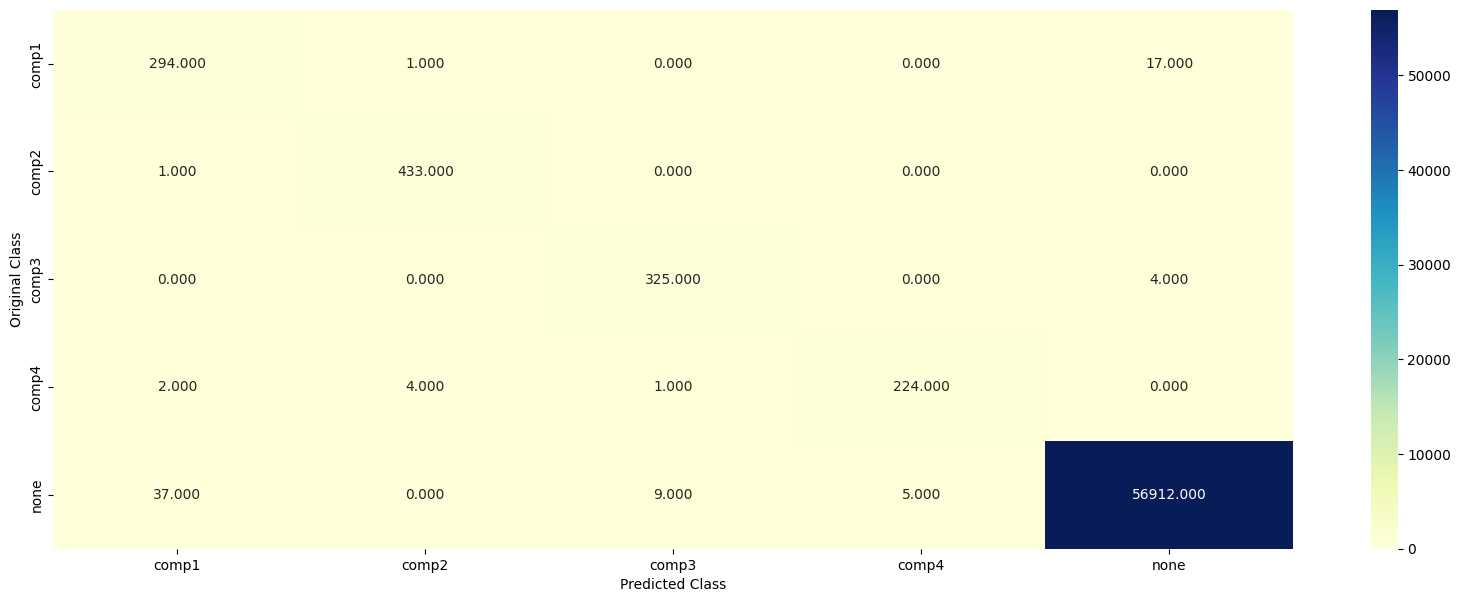

In [ ]:
# Make predictions on test set
y_pred3 = Extra_clf.predict(X_test)

# Calculate classification report
report = classification_report(y_test, y_pred3)

# Save main results
macro_recall_3 = (classification_report(y_test, y_pred3, output_dict = True))

# Print results
print(report)

# Plot confusion matrix
plot_confusion_matrix(y_test, Extra_clf.predict(X_test))

### Support Vector Machines Classifier

Support Vector Machines (SVM) is a powerful and widely used machine learning algorithm that can be used for both classification and regression tasks. SVM is based on the idea of finding a hyperplane that best separates the data into different classes. The algorithm maximizes the margin between the hyperplane and the closest data points, which helps to minimize overfitting and improve generalization performance. SVM can be used with different kernel functions to map the data into higher dimensional space where it is easier to find a separating hyperplane. 

In [ ]:
from sklearn import svm

# Create Support Vector Machine Classifier object
SVM_clf = svm.SVC(kernel='linear', random_state=42)
SVM_clf.fit(X_train,y_train)

SVC(kernel='linear', random_state=42)

              precision    recall  f1-score   support

           0       0.82      0.97      0.89       312
           1       0.97      1.00      0.98       434
           2       0.96      0.98      0.97       329
           3       0.97      0.96      0.96       231
           4       1.00      1.00      1.00     56963

    accuracy                           1.00     58269
   macro avg       0.94      0.98      0.96     58269
weighted avg       1.00      1.00      1.00     58269

-------------------- Confusion matrix --------------------


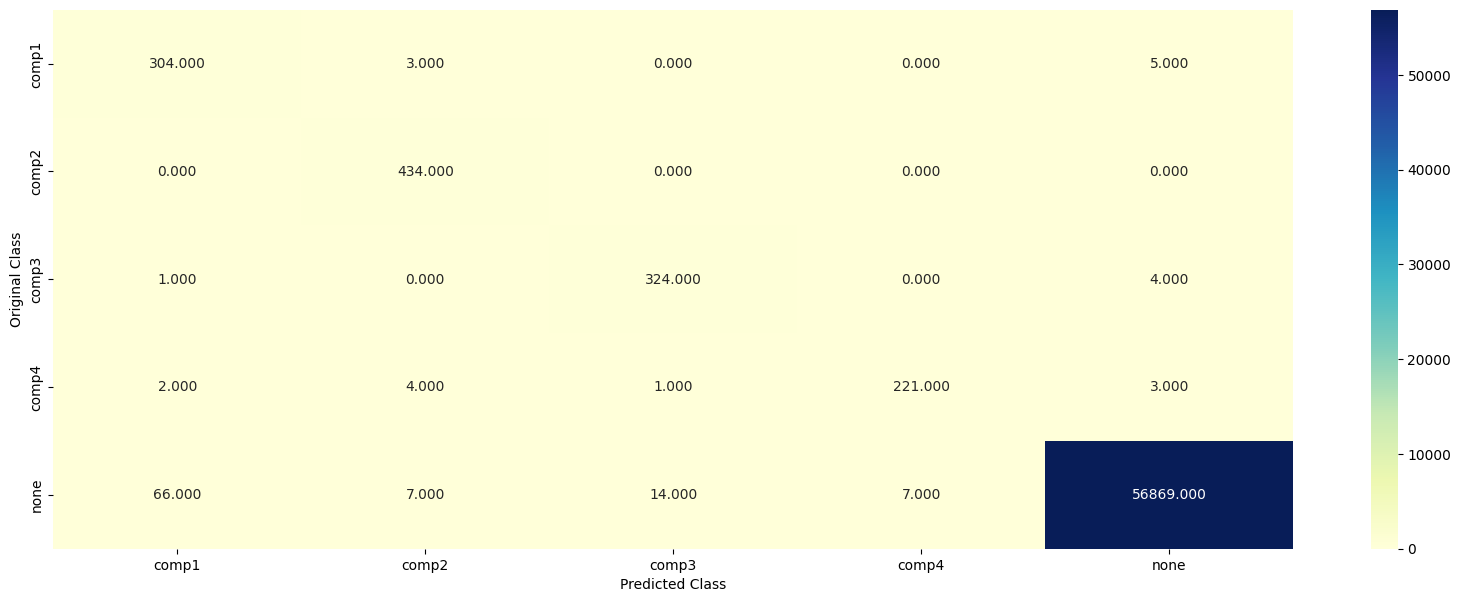

In [124]:
# Make predictions on test set
y_pred4 = SVM_clf.predict(X_test)

# Calculate classification report
report = classification_report(y_test, y_pred4)

# Save main results
macro_recall_4 = (classification_report(y_test, y_pred4, output_dict = True))

# Print results
print(report)

# Plot confusion matrix
plot_confusion_matrix(y_test, SVM_clf.predict(X_test))

### Summary of results

In [125]:
# Create dictionary
data_results = {'model': ['XGB', 'Random Forest', 'Extra Trees', 'SVM'],
        'AVG Recall': [macro_recall_1['macro avg']['recall'], macro_recall_2['macro avg']['recall'], macro_recall_3['macro avg']['recall'], macro_recall_4['macro avg']['recall']]}

# DataFrame
data_results = pd.DataFrame(data_results)
data_results

# Sort by Recall
data_results.sort_values(by='AVG Recall', ascending=False)

,model,AVG Recall
0,XGB,0.986862
3,SVM,0.982844
2,Extra Trees,0.979329
1,Random Forest,0.975615


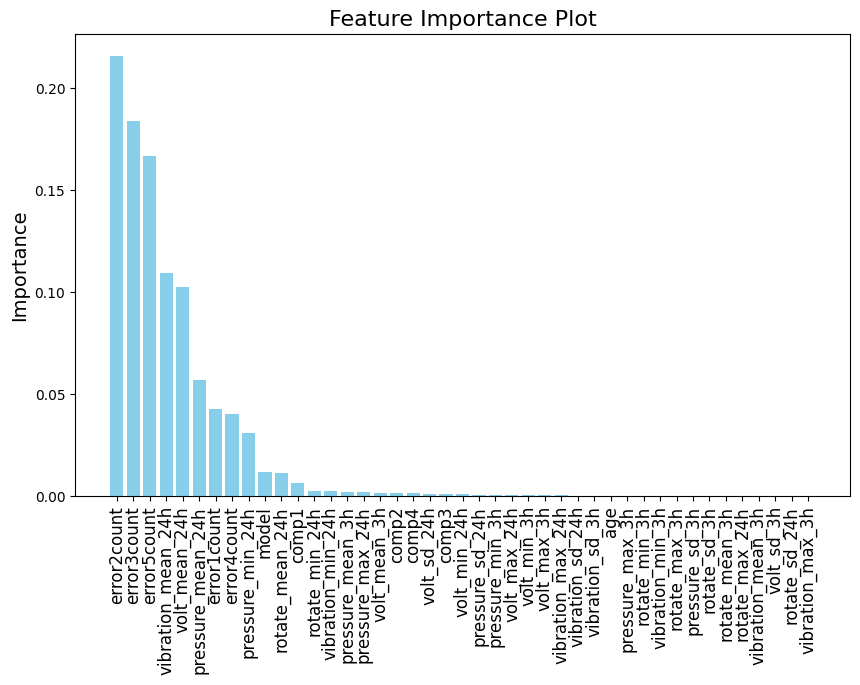

In [127]:
# Feature importance of the chosen model (XGB Classifier)

fig, ax = plt.subplots(figsize=(10, 6))

# Sort features by importance
sorted_features = x_cfl.feature_importances_.argsort()[::-1]

# Create list of feature names and their importance scores
feature_names = pd.DataFrame(X_train, columns = X.columns).columns
feature_importance = x_cfl.feature_importances_

# Plot feature importances
ax.bar(range(len(feature_names)), feature_importance[sorted_features], color='skyblue')

# Set x-tick labels to feature names
ax.set_xticks(range(len(feature_names)))
ax.set_xticklabels(feature_names[sorted_features], rotation=90, fontsize=12)

# Set y-axis label
ax.set_ylabel('Importance', fontsize=14)

# Set title
ax.set_title("Feature Importance Plot", fontsize=16)

# Show plot
plt.show()

### Conclusion

- In this example, hyperparameters and optimization models were not applied, but it is a good practice for future updates.
- Recall was the main model validation metric because it focuses on minimizing false negatives, which means correctly identifying all positive cases (when failure occurs, because changing a component before the right time is still less expensive than corrective maintenance that result in costly consequences such as unplanned downtime, maintenance delays, or safety hazards).
- The XGBoost classifier outperformed the other classifier in predicting component failure in advance. With a recall of 0.986862.